Supplementary material for
# An experimental approach for the determination of axial and flexural wavenumbers in circular exponentially tapered bars

### by [Michał K. Kalkowski](mailto:M.Kalkowski@soton.ac.uk), Jen M Muggleton and Emiliano Rustighi
Institute of Sound and Vibration Research. University of Southampton, UK

Published in Journal of Sound and Vibration, Volume 390, 3 March 2017, Pages 67-85, ISSN 0022-460X, http://dx.doi.org/10.1016/j.jsv.2016.10.018.
(http://www.sciencedirect.com/science/article/pii/S0022460X1630551X)

This Jupyter notebook allows for recreating all figures containing data or results. Measured data are supplied in `.txt` files alongside the notebook, whereas results of numerical/analytical simulations can all be recomputed using the code provided. Simple functions are included in the notebook. Some other, like the piecewise uniform model are in separate .py files that are imported to this notebook. 

This material is copyright (c) 2016 by Michał K. Kalkowski and made available under the [Creaive Commons Attribution](http://creativecommons.org/licenses/by/4.0/) (CC-BY) license. All code is made available under the [MIT license](http://opensource.org/licenses/MIT). The preferred **form of attribution**, should you use either the **code** or the **material presented** or joint with this notebook **in any form**, is **to cite the associated publication** as follows:

Michał K. Kalkowski, Jen M. Muggleton, Emiliano Rustighi, An experimental approach for the determination of axial and flexural wavenumbers in circular exponentially tapered bars, Journal of Sound and Vibration, Volume 390, 3 March 2017, Pages 67-85, ISSN 0022-460X,
http://dx.doi.org/10.1016/j.jsv.2016.10.018
(http://www.sciencedirect.com/science/article/pii/S0022460X1630551X)

The material is also available as a GitHub repository (https://github.com/michalkalkowski/waves_in_tapered_bars)
and if any changes to the code are necessary, the GitHub repository will always contain the most up-to-date version.


In [1]:
# compatibility with Python 2
from __future__ import division
from __future__ import print_function

# import standard packages
import numpy as np
import cmath
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import inv
from itertools import product, cycle

# I included the piecewise uniform model functions and Timoshenko/WKB functions in separate module
import piecewise_uniform as pu

# Configure graphs
plt.style.use('styles/jsv.mplstyle')
tbl10_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
matplotlib.rcParams['savefig.dpi'] = 600

# Functions responsible for setting the plot properties and layout as desired
# define figure sizes
def set_fig_size(fig_width=None, fig_height=None, columns=1, rows=1):
    """Set up figure sizes to look reasonably good in a JSV paper.
    adapted from http://nipunbatra.github.io/2014/08/latexify/
    
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 1.5, 2} (how wide the figure should be as compared to the journal size) 
    rows : {1, 2} (how many rows for subplots does the figure have)
    """
    assert(columns in [1, 1.5, 2])
    
    if fig_width is None:
        if columns == 1:
            fig_width = 3.25
        elif columns==1.5:
            fig_width = 4.87
        else:
            fig_width = 6.5 # width in inches

    if fig_height is None:
        if rows == 1 and (columns == 1 or columns ==2):
            golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
            fig_height = 3.25*golden_mean # height in inches
        elif rows == 2:
            golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
            fig_height = 2*3.25*golden_mean # height in inches
        elif rows == 1 and columns == 1.5:
            golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
            fig_height = 4.87*golden_mean # height in inches

    params = {'figure.figsize': [fig_width,fig_height]}
    matplotlib.rcParams.update(params)

# despining the axes
def format_axes(axes):
    """
    Removes top and right spines of the axes.
    adapted from http://nipunbatra.github.io/2014/08/latexify/
    
    Parameters
    ----------
    axes : matplotlib axes object or list of such
    """
    if type(axes) is not list:
        axes = [axes]
    for ax in axes:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_linewidth(0.5)

        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_tick_params(direction='out')

    return axes

In [2]:
# Definition of other functions (wave propagation related)

def prop_const_from_FRFs(frfs, L, rhs=False):
    """Estimates the wavenumbers from five equally spaced FRF measurements 
    as outlined in the paper.
    
    Parameters
    ----------
    frfs : ndarray, an array with FRFs at five different points (as columns one after another)
    L : float, sensor spacing
    rhs : boolean, if True, the function outputs exp(jkL), rather than k
    """
    p_a, p_b, p_c, p_d, p_e = frfs[:, 2], frfs[:, 3], frfs[:, 4], \
                              frfs[:, 1], frfs[:, 0]
    alpha_n = (p_b*p_e - p_a*p_d)/(p_b*p_d - p_a**2)
    beta_n = (p_d*p_c - p_a*p_b)/(p_b*p_d - p_a**2)
    root = (alpha_n*beta_n*(alpha_n*beta_n - 4))**0.5
    rhs11 = (alpha_n*beta_n + root)/(2*beta_n)
    rhs12 = (alpha_n*beta_n - root)/(2*beta_n)
    rhs21 = 1/(beta_n - 1/rhs11)
    rhs22 = 1/(beta_n - 1/rhs12)
    k11 = np.log(rhs11)/(1j*L)
    k12 = np.log(rhs12)/(1j*L)

    k21 = np.log(rhs21)/(1j*L)
    k22 = np.log(rhs22)/(1j*L)
    if rhs:
        return [rhs11, rhs12, rhs21, rhs22]
    else:
        return [k11, k12, k21, k22]

def timo_wavenumber(E, nu, rho, f, radius=0, G=0):
    """ Calculates wavenumbers according to the Timoshenko beam theory 
    at a given radius (for a circular beam). If radius is an array, 
    the wavenumbers are calculated for all values and output in a 3D array.
    
    Parameters:
    -----------
    E : Young's modulus
    nu : Poisson's ratio
    rho : density
    f : frequencies (as a 1D array)
    radius : radius of the cross-section (can be a 1D array)
    G : Shear modulus, if the material is not isotropic (and G is not related
        to E according the relationship involving Poisson's ratio)
        
    Returns:
    --------
    [k1, k2] : the wavenumbers in the order [bending, shear]
    """
    
    kappa = 6*(1 + nu)/(7 + 6*nu)
    if G == 0:
        G = E/(2*(1 + nu))
    
    A = np.pi*radius**2
    I = A*radius**2/4
    
    Cs = (G*kappa/rho)**0.5
    Cb = (E*I/(rho*A.astype('complex')))**0.5
    Cr = (I/A.astype('complex'))**0.5
    
    omega = 2*np.pi*f.reshape(-1, 1)
    
    #calculating wavenumbers    
    k1 = np.sqrt(omega**2/2*(1/Cs**2 + Cr**2/Cb**2) + 
            np.sqrt(omega**4/4*(1/Cs**2 - Cr**2/Cb**2)**2 + omega**2/Cb**2))
    k2 = np.sqrt(omega**2/2*(1/Cs**2 + Cr**2/Cb**2) -
            np.sqrt(omega**4/4*(1/Cs**2 - Cr**2/Cb**2)**2 + omega**2/Cb**2))
    inds = np.where(abs(np.exp(-1j*k2*0.1))>1)
    k2[inds[0], inds[1]] *= -1
    
    return k1, k2

def WKB_amplitude(E, nu, rho, f, radius, k, G=0):
    """ Calculates the amplitudes of flexural waves according
    to the Timoshenko beam theory resulting from the WKB approximation for a given radius.
    
    Parameters:
    -----------
    E : Young's modulus
    nu : Poisson's ratio
    rho : density
    f : frequencies (as a 1D array)
    radius : radius of the cross-section (can be a 1D array)
    G : Shear modulus, if the material is not isotropic (and G is not related
        to E according the relationship involving Poisson's ratio)
        
    Returns:
    --------
    W : wave amplitudes
    """
    if G == 0:
        G = E/(2*(1 + nu))

    A = np.pi*radius**2
    I = np.pi/4*radius**4

    omega = 2*np.pi*f.reshape(-1, 1)
    kappa = 6*(1 + nu)/(7 + 6*nu)
    mu = 0.5*(I/A)*(E/(kappa*G) - 1)*(omega**2*rho/(kappa*G) - k**2)
    
    W = k**0.5/((rho*A)**0.5*(1 + mu)**0.5)
    return W


# define the material properties used for the notebook
class Properties(object):
    """
    Class definig mechanical and geometrical properties of
    an exponentially tapered bar (an overkill to make it a class, but...)"""
    def __init__(self, case):
        if case == 'example':
            self.E = 10e9*(1 + 0.005j)
            self.rho = 700
            self.nu = 0.33
            self.beta = 1.55
            self.L = 2
            self.R0 = 0.1
        elif case == 'experiment':
            self.R0 = 0.0945
            self.E = 1.38904980e+10*(1 + 0.0073j)   
            self.rho = 531.117258
            self.L = 2.00698533
            self.beta = 1.64295946
            self.nu = 0.33
common = Properties('example')
common_exp = Properties('experiment')

# Axial wave propagation - analytical model

In [3]:
# define the frequency vector
f1, f2, res = 1, 5000, 500
f = np.linspace(f1, f2, res)
omega = 2*np.pi*f

# uniform rod wavenumber
kn = omega*cmath.sqrt(common.rho/common.E)
# cut-off frequency
omega_c = common.beta*np.sqrt(common.E/common.rho)
# area at the large face
A0 = np.pi*common.R0**2

# dispersion curves for the tapered rod
k = np.zeros([len(omega), 2], 'complex')
for i in range(len(omega)):
    if omega[i]<omega_c:
        k[i, :] = [1j*(common.beta - np.sqrt(common.beta**2 - kn[i]**2)),
                   1j*(common.beta + np.sqrt(common.beta**2 - kn[i]**2))]
    else:
        k[i, :] = [(np.sqrt(kn[i]**2 - common.beta**2)) + 1j*common.beta, 
                  -(np.sqrt(kn[i]**2 - common.beta**2)) + 1j*common.beta]

# forced response at points in x_s
x_s = np.array([0, 0.15, 0.45, 0.75, 1.05, 1.35, common.L])
res_x = len(x_s)
x_f = 0
u_rod = np.zeros([res, res_x], 'complex')

# reflection matrices
Rr = -k[:, 0]/k[:, 1]
Rl = -k[:, 1]/k[:, 0]

# analytical wave approach calculation
# see e.g. Y. Waki, On the application of finite element analysis to wave motion in one-dimensional waveguides
tauRp = np.zeros(res, 'complex')
tauRn = np.zeros(res, 'complex')
for i, j in product(range(res), range(res_x)):
    tauL = 1
    tauRp[i] = np.exp(-1j*k[i, 0]*(common.L))
    tauRn[i] = np.exp(-1j*(k[i, 0].real - 1j*k[i, 1].imag)*(common.L))
    A_f = A0*np.exp(-2*common.beta*x_f)
    e_pos = -1j/(common.E*A_f*k[i, 0])
    a_pos = (1 - Rl[i]*tauRn[i]*Rr[i]*tauRp[i])**(-1)*(e_pos)
    u_rod[i, j] = a_pos*np.exp(-1j*k[i, 0]*x_s[j]) + \
                    np.exp(-1j*(k[i, 0].real - 1j*k[i, 1].imag)*\
                           (common.L - x_s[j]))*Rr[i]*np.exp(-1j*k[i, 0]*common.L)*a_pos

/home/michal/anaconda2/envs/py3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


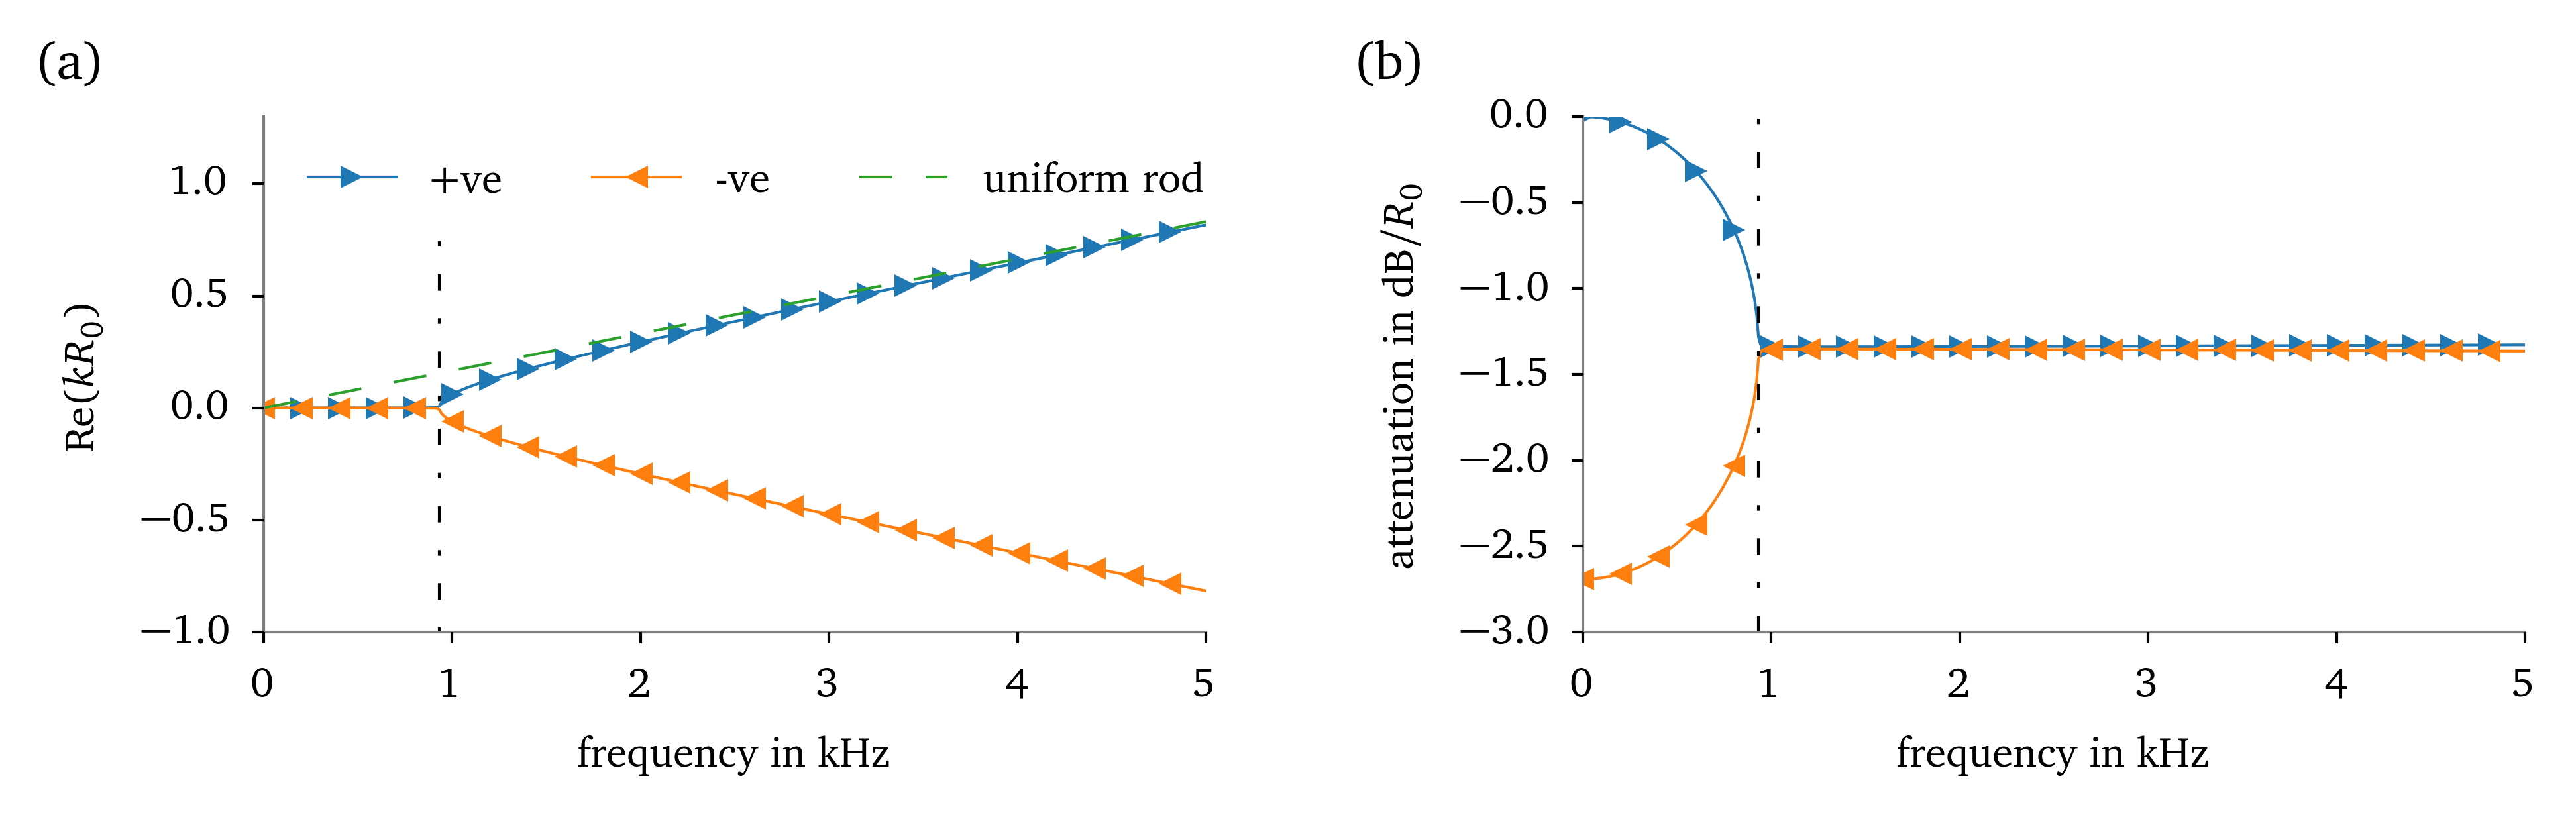

In [4]:
# Plot te dispersion curves (Figure 1)
%matplotlib inline
set_fig_size(columns=2)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(f/1e3, k.real[:, 0]*common.R0, marker='>', markevery=20)
ax1.plot(f/1e3, k.real[:, 1]*common.R0, marker='<', markevery=20)
ax2.plot(f/1e3, k.imag[:, 0]*-20/np.log(10)*common.R0, marker='>', markevery=20)
ax2.plot(f/1e3, k.imag[:, 1]*-20/np.log(10)*common.R0, marker='<', markevery=20)
ax1.plot(f/1e3, 2*np.pi*f*np.sqrt(common.rho/common.E)*common.R0, '--') 
ax1.plot([common.beta*np.sqrt(common.E/common.rho)/2e3/np.pi,
          common.beta*np.sqrt(common.E/common.rho)/2e3/np.pi], [-1.2, .85], '-.', color='black')
ax2.plot([common.beta*np.sqrt(common.E/common.rho)/2e3/np.pi,
          common.beta*np.sqrt(common.E/common.rho)/2e3/np.pi], [-3, 0], '-.', color='black')
ax2.set_xlabel('frequency in kHz')
ax1.set_xlabel('frequency in kHz')

ax1.set_ylabel('Re($k R_0$)')
ax2.set_ylabel('attenuation in dB/$R_0$')
ax1.legend(['+ve', '-ve', 'uniform rod'], loc=2, ncol=3)
ax1.set_ylim([-1, 1.3])
ax1.annotate("(a)", xy=(-.1, 1.05), xycoords=("axes fraction"),
                  xytext=(-.2,1.05), textcoords=("axes fraction"),
                  va="bottom", ha="center")
ax2.annotate("(b)", xy=(-.1, 1.05), xycoords=("axes fraction"),
                  xytext=(-.2,1.05), textcoords=("axes fraction"),
                  va="bottom", ha="center")

format_axes([ax1, ax2])
fig.tight_layout()
fig.subplots_adjust(wspace = 0.4)
fig.savefig('Figures/Figure1.pdf', dpi=600)

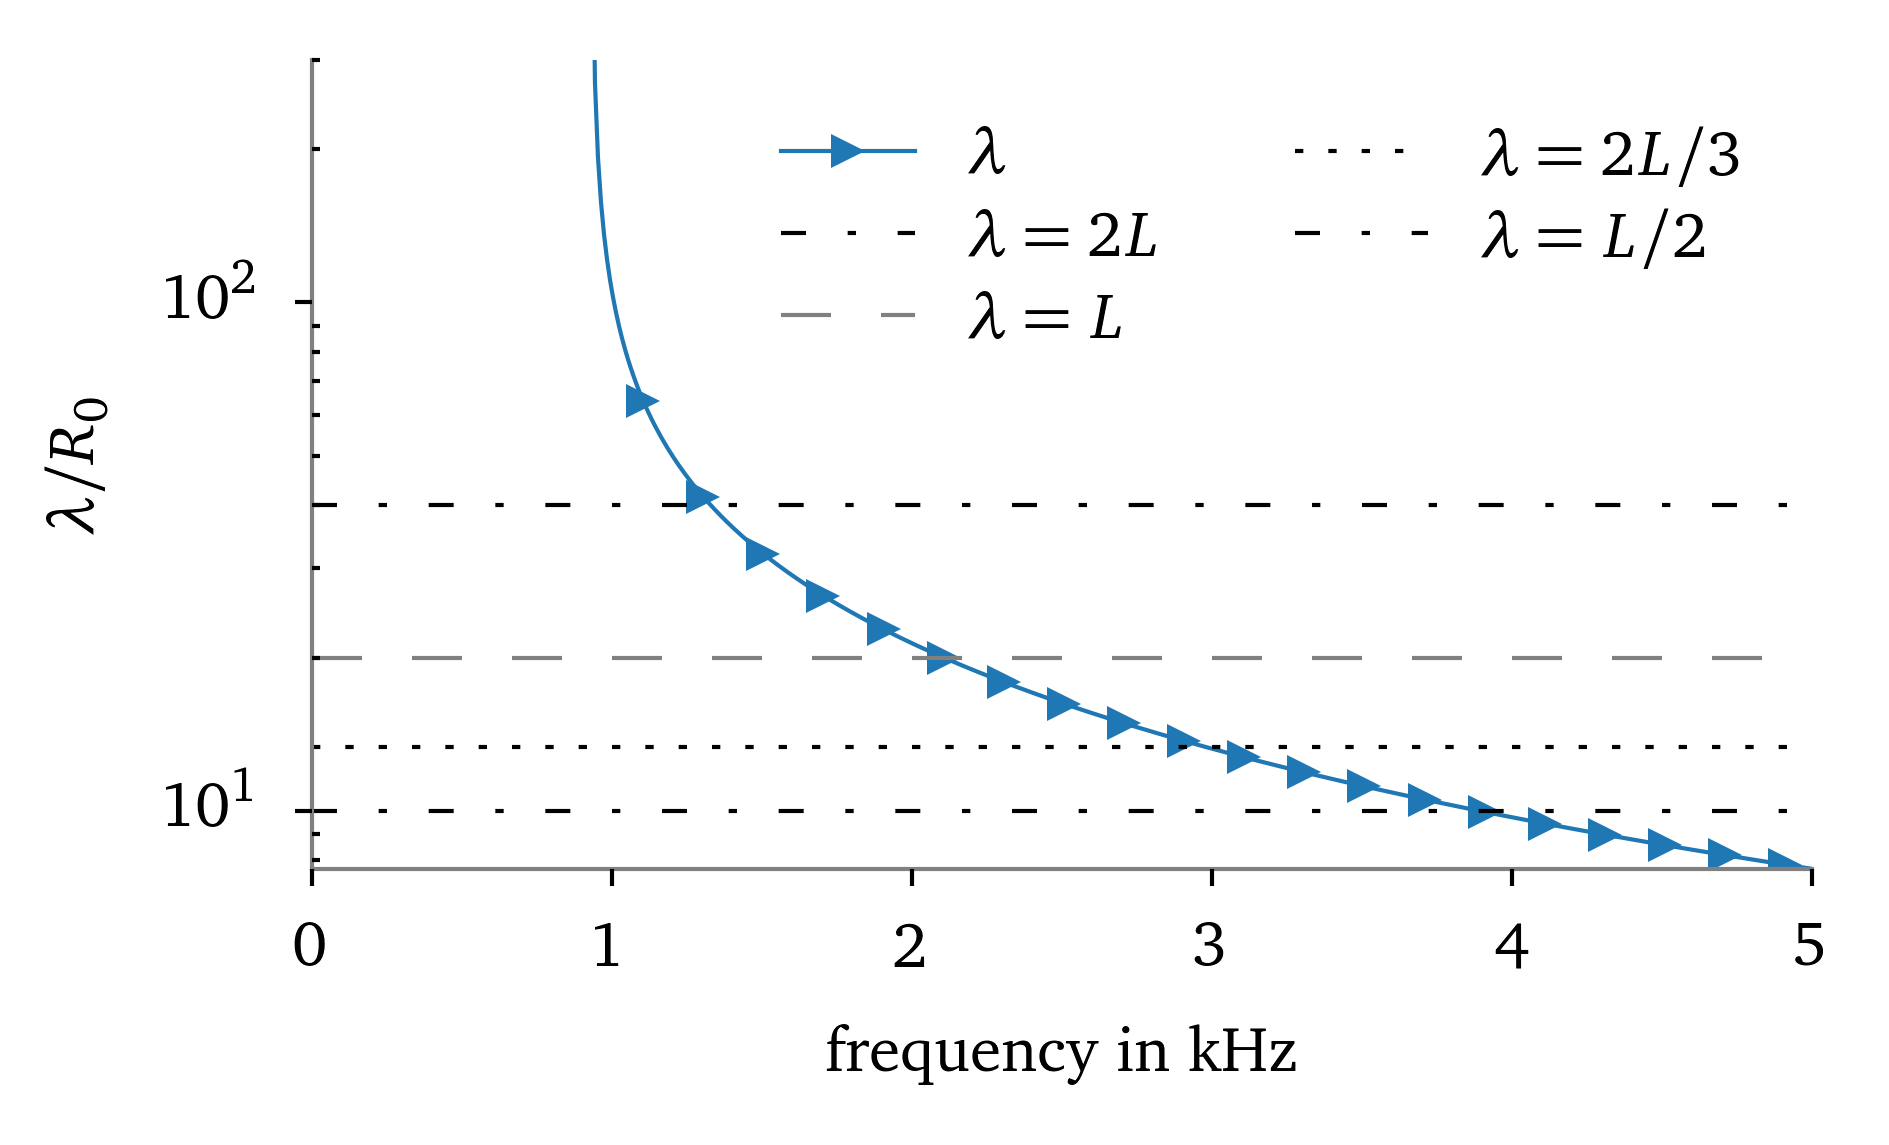

In [5]:
# Plot the rod wavelength (Figure 2)
set_fig_size(columns=1)
fig, ax = plt.subplots()
ax.semilogy(f[90:]/1e3, 2*np.pi/k.real[90:, 0]/common.R0, marker='>', markevery=20)
ax.semilogy([0, 5], [2*common.L/common.R0, 2*common.L/common.R0], '-.', color='black')
ax.semilogy([0, 5], [common.L/common.R0, common.L/common.R0], '--', color='gray')
ax.semilogy([0, 5], [2*common.L/common.R0/3, 2*common.L/common.R0/3], ':', color='black')
ax.semilogy([0, 5], [2*common.L/common.R0/4, 2*common.L/common.R0/4], '-.', color='black')
ax.set_xlabel('frequency in kHz')
ax.set_ylabel('$\lambda/R_0$')
ax.legend([r'$\lambda$', r'$\lambda=2L$', r'$\lambda=L$', r'$\lambda=2L/3$', r'$\lambda=L/2$'],ncol=2)
ax.set_xlim([0, 5]);
ax.set_ylim([0, 300]);
format_axes(ax)
fig.tight_layout()
fig.savefig('Figures/Figure2.pdf', dpi=600)

# Experiments


In [6]:
# axial wave calculations for using the properties of the experimental specimen (updated properties)

kn = omega*cmath.sqrt(common_exp.rho/common_exp.E)
omega_c = common_exp.beta*np.sqrt(common_exp.E/common_exp.rho)

A0 = np.pi*common_exp.R0**2

#dispersion curves
k = np.zeros([len(omega), 2], 'complex')
for i in range(len(omega)):
    if omega[i]<omega_c:
        k[i, :] = [1j*(common_exp.beta - np.sqrt(common_exp.beta**2 - kn[i]**2)),
                   1j*(common_exp.beta + np.sqrt(common_exp.beta**2 - kn[i]**2))]
    else:
        k[i, :] = [(np.sqrt(kn[i]**2 - common_exp.beta**2)) + 1j*common_exp.beta, 
                  -(np.sqrt(kn[i]**2 - common_exp.beta**2)) + 1j*common_exp.beta]

#forced response
x_s = np.array([0, 0.15, 0.45, 0.75, 1.05, 1.35, common_exp.L])
res_x = len(x_s)
x_f = 0
u_rod = np.zeros([res, res_x], 'complex')
Rr = -k[:, 0]/k[:, 1]
Rl = -k[:, 1]/k[:, 0]
tauRp = np.zeros(res, 'complex')
tauRn = np.zeros(res, 'complex')
for i, j in product(range(res), range(res_x)):
    tauL = 1
    tauRp[i] = np.exp(-1j*k[i, 0]*(common_exp.L))
    tauRn[i] = np.exp(-1j*(k[i, 0].real - 1j*k[i, 1].imag)*(common_exp.L))
    A_f = A0*np.exp(-2*common_exp.beta*x_f)
    e_pos = -1j/(common_exp.E*A_f*k[i, 0])
    a_pos = (1 - Rl[i]*tauRn[i]*Rr[i]*tauRp[i])**(-1)*(e_pos)
    u_rod[i, j] = a_pos*np.exp(-1j*k[i, 0]*x_s[j]) + \
                    np.exp(-1j*(k[i, 0].real - 1j*k[i, 1].imag)*(common_exp.L - x_s[j]))*Rr[i]*np.exp(-1j*k[i, 0]*common_exp.L)*a_pos

In [7]:
# Load measured input and transfer accelerances

exp_point_FRF_file = np.genfromtxt('data/rod_input_FRF_acc.txt', skip_header=2)
exp_point_FRF = np.c_[exp_point_FRF_file[:, 0], exp_point_FRF_file[:, 1] + 1j*exp_point_FRF_file[:, 2]]

exp_transfer_FRF_file = np.genfromtxt('data/rod_transfer_FRF_acc.txt', skip_header=2)
exp_transfer_FRF = np.c_[exp_transfer_FRF_file[:, 0], exp_transfer_FRF_file[:, 1] + 1j*exp_transfer_FRF_file[:, 2]]

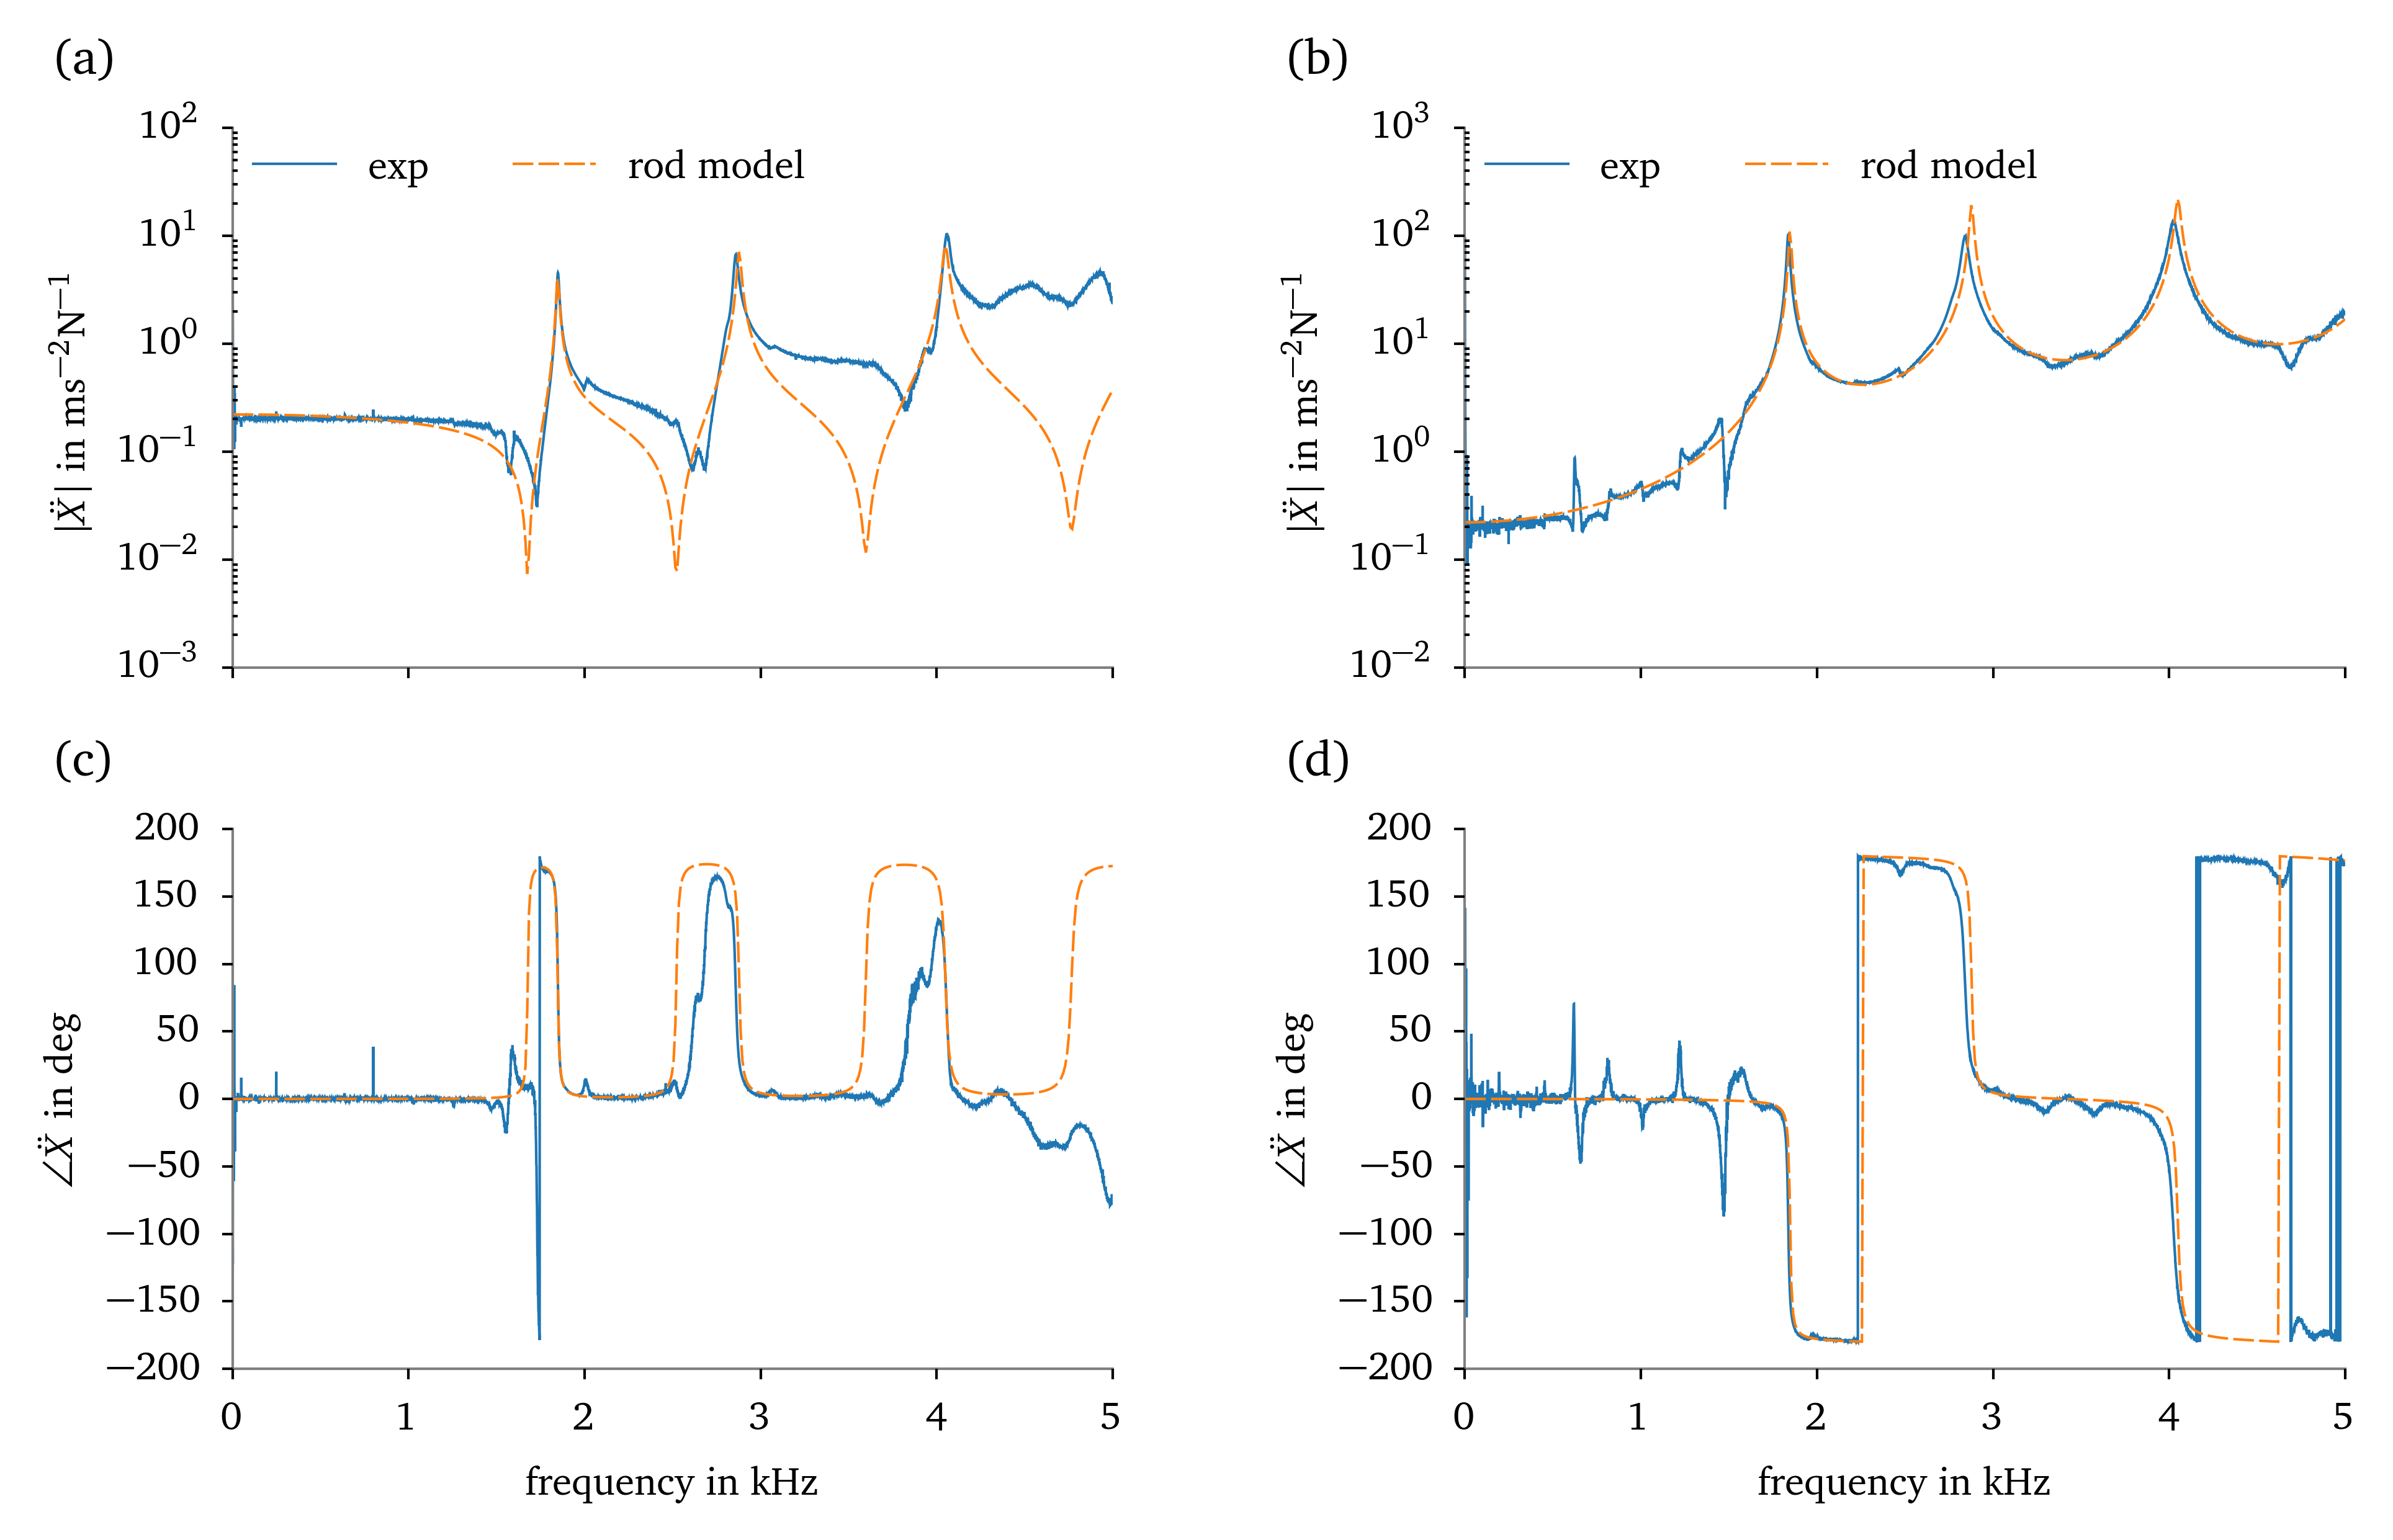

In [8]:
# Plot the analytical predictions against measurements (Figure 5)
set_fig_size(columns=2, rows=2)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)
dashes = [4, 1, 4, 1]
ax1.semilogy(exp_point_FRF[:, 0].real/1e3, abs(exp_point_FRF[:, 1]),  '-',
             label='exp')
line1, = ax1.semilogy(f/1e3, abs(u_rod[:, 0]*(-(2*np.pi*f)**2)), label='rod model', rasterized=True)
line1.set_dashes(dashes)
ax2.semilogy(exp_transfer_FRF[:, 0].real/1e3, abs(exp_transfer_FRF[:, 1]),  '-',
             label='exp', rasterized=True)
line1, = ax2.semilogy(f/1e3, abs(u_rod[:, -1]*(-(2*np.pi*f)**2)), label='rod model', rasterized=True)
line1.set_dashes(dashes)
ax3.plot(exp_point_FRF[:, 0].real/1e3, np.angle(exp_point_FRF[:, 1], True),  '-',
             label='exp', rasterized=True)
line1, = ax3.plot(f/1e3, np.angle(u_rod[:, 0]*(-(2*np.pi*f)**2), True),  label='rod model', rasterized=True)
line1.set_dashes(dashes)
ax4.plot(exp_transfer_FRF[:, 0].real/1e3, np.angle(exp_transfer_FRF[:, 1], True),  '-',
             label='exp', rasterized=True)
line1, = ax4.plot(f/1e3, np.angle(u_rod[:, -1]*(-(2*np.pi*f)**2), True), label='rod model', rasterized=True)
line1.set_dashes(dashes)

ax3.set_xlabel('frequency in kHz')
ax4.set_xlabel('frequency in kHz')

ax1.set_ylabel('$|\ddot{X}|$ in ms$^{-2}$N$^{-1}$')
ax3.set_ylabel(r'$\angle \ddot{X}$ in deg')
ax2.set_ylabel('$|\ddot{X}|$ in ms$^{-2}$N$^{-1}$')
ax4.set_ylabel(r'$\angle \ddot{X} $ in deg')

ax1.legend(ncol=4, loc=2, borderaxespad=0.)
ax2.legend(ncol=4, loc=2, borderaxespad=0.)

ax1.annotate('(a)', xy=(-0.2, 1.1), xycoords='axes fraction')
ax2.annotate('(b)', xy=(-0.2, 1.1), xycoords='axes fraction')
ax3.annotate('(c)', xy=(-0.2, 1.1), xycoords='axes fraction')
ax4.annotate('(d)', xy=(-0.2, 1.1), xycoords='axes fraction')

fig.tight_layout()
fig.subplots_adjust(wspace = 0.4, hspace=0.3)
format_axes([ax1, ax2, ax3, ax4])
plt.show()
fig.savefig('Figures/Figure5.pdf', dpi=600)

## Axial wavenumber estimation

In [9]:
# Load measured FRFs for axial wavenumber estimation
axial_15_FRFs = np.genfromtxt('data/axial_wavenumber_est_15.txt', delimiter=',', skip_header=2, dtype=np.complex128)
axial_30_FRFs = np.genfromtxt('data/axial_wavenumber_est_30.txt', delimiter=',', skip_header=2, dtype=np.complex128)

# set sensor spacing
L_15 = 0.15
L_30 = 0.30

f_axial_15 = axial_15_FRFs[:, 0]
f_axial_30 = axial_30_FRFs[:, 0]

axial_15_FRFs_added = np.zeros([len(axial_15_FRFs), 5], 'complex')
axial_30_FRFs_added = np.zeros([len(axial_30_FRFs), 5], 'complex')

# Add the four FRFs around each circumference and divide by 4 to eliminate 
# the contribution of non-axisymmetric waves
for index, column in enumerate([1, 5, 9, 13, 17]):
    axial_15_FRFs_added[:, index] = np.sum(axial_15_FRFs[:, column:column + 4], axis=1)/4
    axial_30_FRFs_added[:, index] = np.sum(axial_30_FRFs[:, column:column + 4], axis=1)/4
    
# Estimate the wavenumbers using the 5 sensors approach
k_15 = prop_const_from_FRFs(axial_15_FRFs_added, L_15)
k_30 = prop_const_from_FRFs(axial_30_FRFs_added, L_30)
# use only one sensor at each location (no ring)
k_30_line = prop_const_from_FRFs(axial_30_FRFs[:, 3::4], L_30)

#plot the results
# this is only a helper function used locally, so no docstring, etc.
def plot_axial_estimates(f_est, k_est, k_ylim, att_ylim, fname=0):
    set_fig_size(columns=2, rows=1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(f_est.real/1e3, k_est[0].real*common_exp.R0, 'o', ms=2, 
             color=tbl10_colors[8], label='experiment', rasterized=True)
    ax1.plot(f_est.real/1e3, k_est[1].real*common_exp.R0, 'o', ms=2, 
             color=tbl10_colors[8], rasterized=True)
    ax1.plot(f/1e3, k[:, 0].real*common_exp.R0, lw=2, color=tbl10_colors[0], ls='--', 
             label = 'analytical', rasterized=True)
    ax1.plot(f/1e3, k[:, 1].real*common_exp.R0, lw=2, color=tbl10_colors[0], ls='--',
             rasterized=True)
    ax1.set_ylim(k_ylim)
    ax1.set_xlabel('frequency in kHz')
    ax1.legend(ncol=2)
    ax2.plot(f_est.real/1e3, -k_est[0].imag*common_exp.R0*20/np.log(10), 'o', ms=2, 
             color=tbl10_colors[8], label='exp', rasterized=True)
    ax2.plot(f_est.real/1e3, -k_est[1].imag*common_exp.R0*20/np.log(10), 'o',  ms=2,
             color=tbl10_colors[8], label='exp', rasterized=True)
    ax2.plot(f/1e3, -k.imag*common_exp.R0*20/np.log(10), lw=2, color=tbl10_colors[0], ls='--', 
             label = 'analytical', rasterized=True)
    ax2.set_xlabel('frequency in kHz')
    ax1.set_ylabel('Re($k R_0$)')
    ax2.set_ylabel('attenuation in dB/$R_0$')
    ax2.set_ylim(att_ylim)
    ax1.annotate('(a)', xy=(-0.2, 1.05), xycoords='axes fraction')
    ax2.annotate('(b)', xy=(-0.2, 1.05), xycoords='axes fraction')
    fig.tight_layout()
    format_axes(ax1)
    format_axes(ax2)
    if fname != 0:
        fig.savefig(fname, dpi=600)
    plt.show()

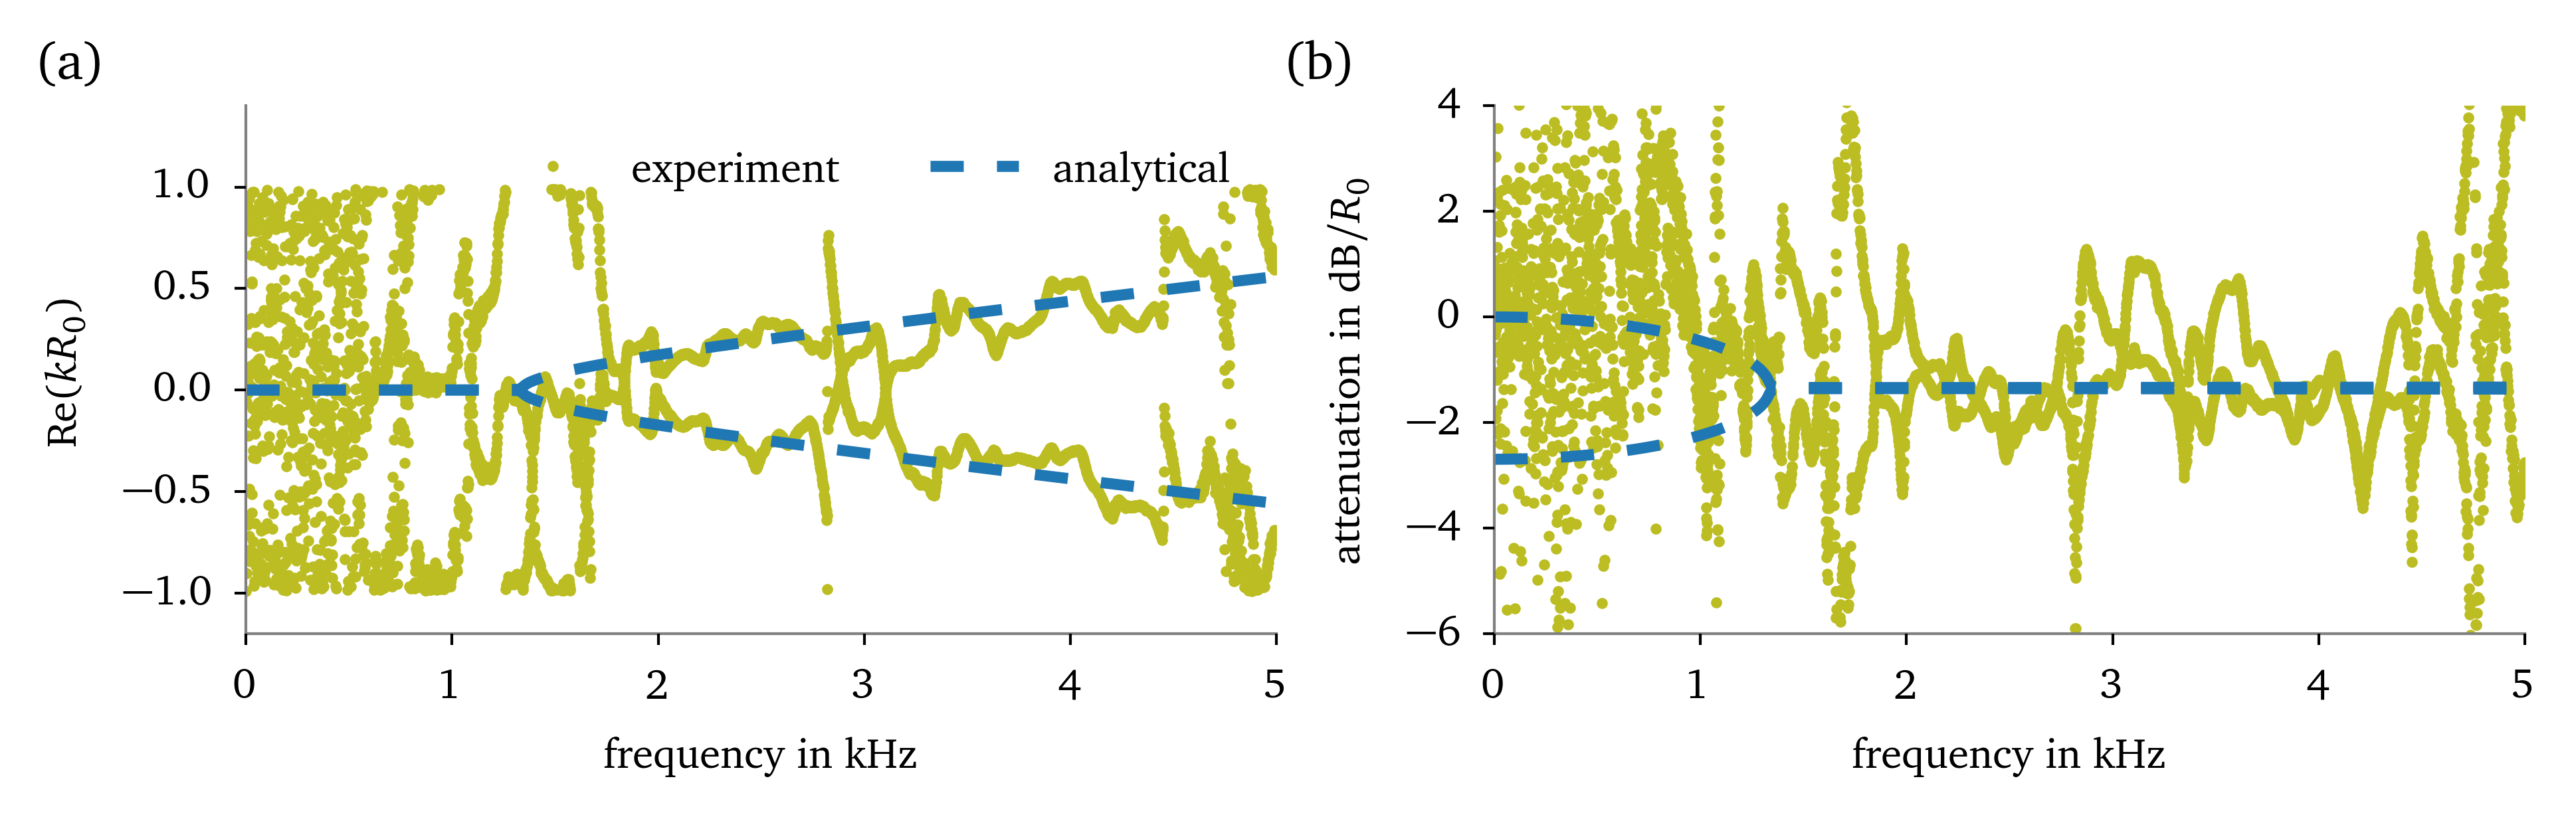

In [10]:
# Wavenumber estimates if only one sensor at each location was used (no ring)
plot_axial_estimates(f_axial_30, k_30_line, [-1.2, 1.4], [-6, 4])

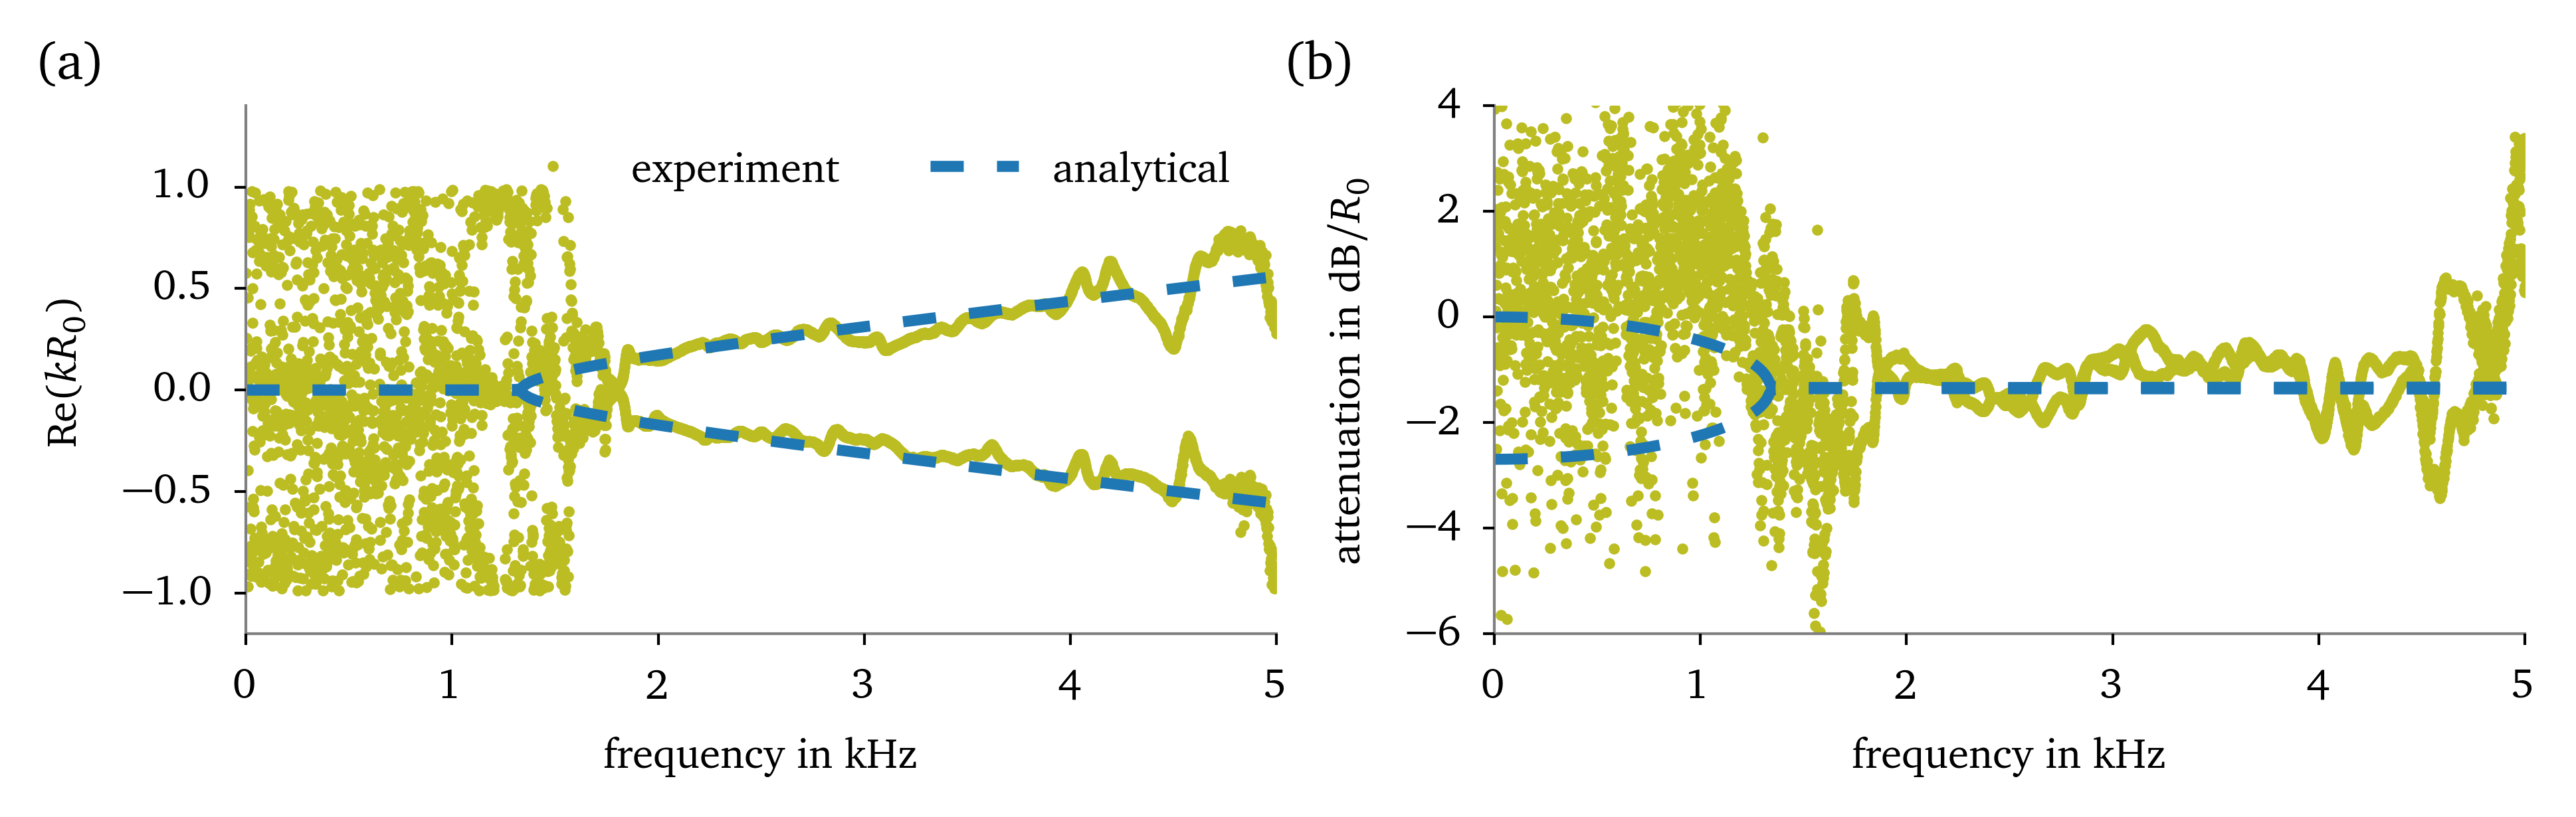

In [11]:
# Fig. 6
plot_axial_estimates(f_axial_30, k_30, [-1.2, 1.4], [-6, 4], fname='Figures/Figure6.pdf')

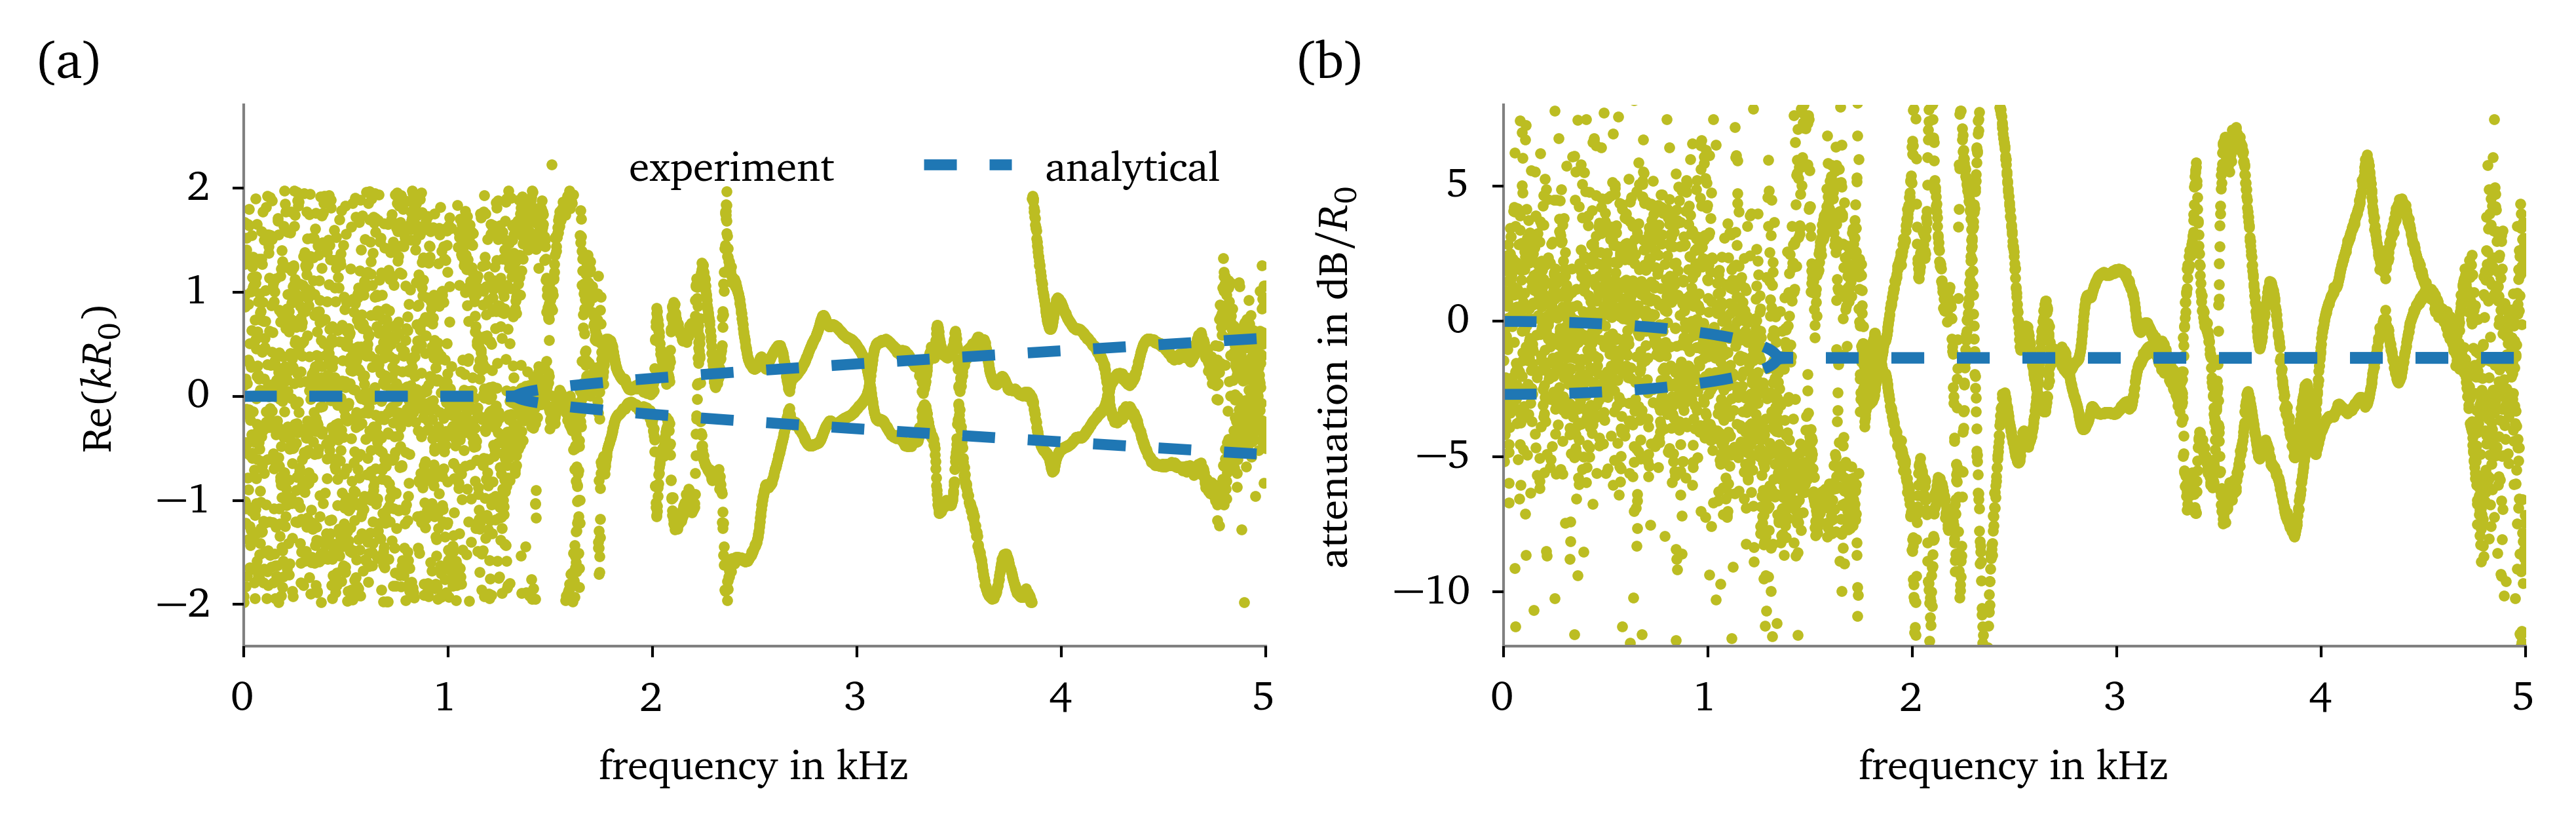

In [12]:
# Fig. 7
plot_axial_estimates(f_axial_30, k_15, [-2.4, 2.8], [-12, 8], fname='Figures/Figure7.pdf')

## Flexural waves - piecewise uniform model

In [13]:
# set the properties for the flexural part
# parameters coming from the beam FRF uptdating to adjust E and identify the E/G ratio
params =  [1.1277,  1/17.14]

E = params[0]*common_exp.E.real*(1 + 0.02j)
G = params[1]*E.real*(1 + 1j*0.02)
rho = common_exp.rho
nu = common_exp.nu
beta = common_exp.beta
kappa = 6*(1 + nu)/(7 + 6*nu)
R0 = common_exp.R0
L = common_exp.L

# number of piecewise elements
n_el = 100
# locations of the desired response locations from the numerical model
x_Ls = np.r_[[0.001], np.arange(0.0, L, 0.005)]
radius = R0*np.exp(-beta*x_Ls)


In [14]:
# definition of necessary functions

def dispe_num(centre, spacing, x_Ls, FRFs):
    """
    Calculates the wave number estimates from the numerical results using the 5-sensors method.
    
    Parameters:
    -----------
    centre : the central location
    spacing : sensor spacing
    x_Ls : locations of the FRFs
    FRFs : FRFs matrix
    """
    center_ind = np.where(np.round(x_Ls, 3)==centre)[0][0]
    distance = center_ind - np.where(np.round(x_Ls, 3)==round(centre-spacing,3))[0][0]
    frfs_ind = [center_ind - (2 - d)*distance for d in range(0, 5)]
    return prop_const_from_FRFs(FRFs[:, frfs_ind], spacing)

def WKB_k_imag(centre, spacing, x_Ls, WKB_ampls):
    """
    Calculates the WKB approximation for wave attenuation.
        
    Parameters:
    -----------
    centre : the central location
    spacing : sensor spacing
    x_Ls : locations of the FRFs
    WKB_ampls : WKB amplitudes calculated as given by Pierce(1969) at the x_Ls locations
    """
    center_ind = np.where(np.round(x_Ls, 3)==centre)[0][0]
    distance = center_ind - np.where(np.round(x_Ls, 3)==round(centre-spacing,3))[0][0]
    return np.real(np.log(WKB_ampls[:, center_ind+2*distance]/WKB_ampls[:, center_ind - 2*distance]))/spacing/4


In [15]:
# compute numerical prediction using the piecewise constant model
resp_pu, nat_frq_pu = pu.piecewise_uniform_beam(f, E, nu, rho, R0, L, 
                                                       beta, n_el, x_Ls, G=G, nat=True)
# convert receptances from the piecewise uniform model to accelerances
resp_pu  = -(2*np.pi*f.reshape(-1, 1))**2*resp_pu
# calculate analytical Timoshenko wavenumbers at x_Ls locations
k_an_real = timo_wavenumber(E, nu, rho, f, radius, G=G)

# calculate WKB amplitudes as given by Pierce(1969) at x_Ls locations
WKB_ampls = [WKB_amplitude(E, nu, rho, f, radius, k_an_real[0], G=G), 
             WKB_amplitude(E, nu, rho, f, radius, k_an_real[1], G=G)]

# Experiments

In [16]:
# Load the experimental input and transfer FRF measurements
exp_point_FRF_file = np.genfromtxt('data/beam_input_FRF.txt', skip_header=2, delimiter=',')
exp_point_FRF = np.c_[exp_point_FRF_file[:, 0], exp_point_FRF_file[:, 1] + 1j*exp_point_FRF_file[:, 2]]

exp_transfer_FRF_file = np.genfromtxt('data/beam_transfer_FRF.txt', skip_header=2, delimiter=',')
exp_transfer_FRF = np.c_[exp_transfer_FRF_file[:, 0], exp_transfer_FRF_file[:, 1] + 1j*exp_transfer_FRF_file[:, 2]]

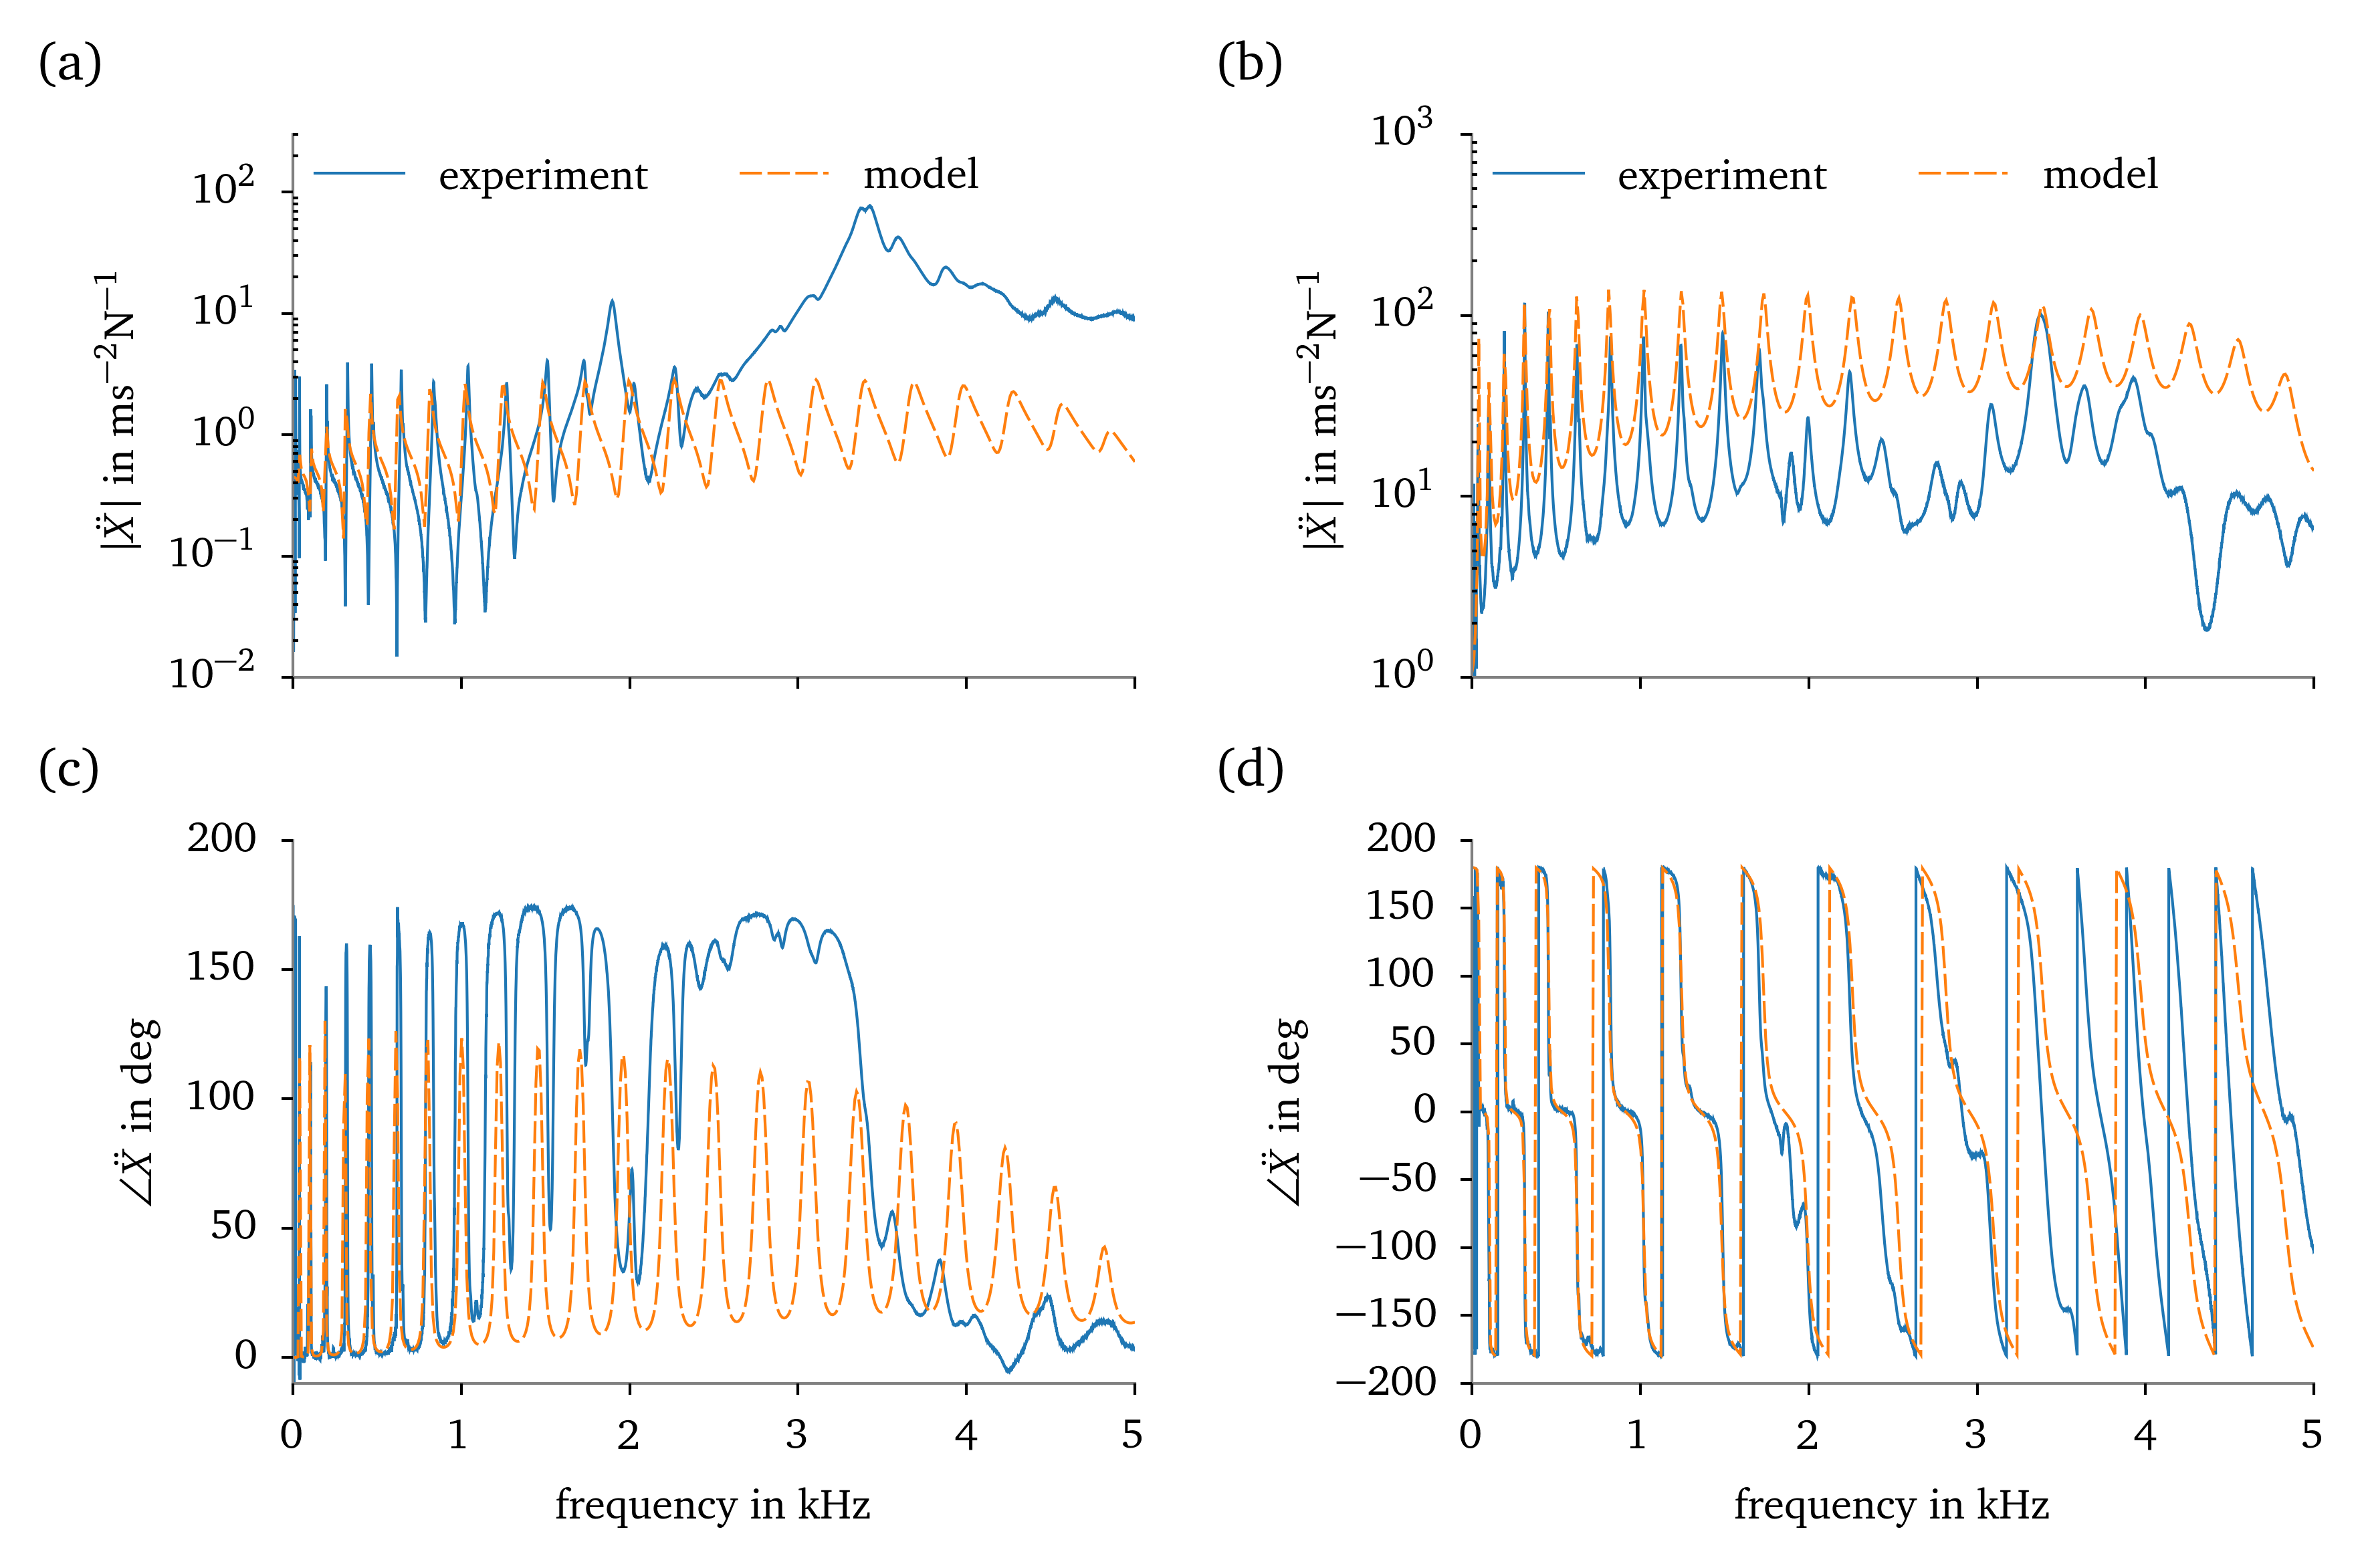

In [17]:
# Plot the measured FRFs against the predictions from the piecewise uniform model (Fig. 10)

set_fig_size(columns=2, rows=2)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)
dashes = [4, 1, 4, 1]
ax1.semilogy(exp_point_FRF[:, 0].real/1e3, abs(exp_point_FRF[:, 1]),  '-',
             label='experiment', rasterized=True)
line1, = ax1.semilogy(f/1e3, abs(resp_pu[:, 0]), label='model', rasterized=True)
line1.set_dashes(dashes)
ax2.semilogy(exp_transfer_FRF[:, 0].real/1e3, abs(exp_transfer_FRF[:, 1]),  '-',
             label='experiment', rasterized=True)
line2, = ax2.semilogy(f/1e3, abs(resp_pu[:, -1]), label='model', rasterized=True)
line2.set_dashes(dashes)
ax3.plot(exp_point_FRF[:, 0].real/1e3, np.angle(exp_point_FRF[:, 1], True),  '-',
             label='experiment', rasterized=True)
line3, = ax3.plot(f/1e3, np.angle(resp_pu[:, 0], True),  label='model', rasterized=True)
line3.set_dashes(dashes)
ax4.plot(exp_transfer_FRF[:, 0].real/1e3, np.angle(exp_transfer_FRF[:, 1], True),  '-',
             label='experiment', rasterized=True)
line4, = ax4.plot(f/1e3, np.angle(resp_pu[:, -1], True),  label='model', rasterized=True)
line4.set_dashes(dashes)
ax3.set_xlabel('frequency in kHz')
ax4.set_xlabel('frequency in kHz')

ax1.set_ylabel('$|\ddot{X}|$ in ms$^{-2}$N$^{-1}$')
ax3.set_ylabel(r'$\angle \ddot{X}$ in deg')
ax2.set_ylabel('$|\ddot{X}|$ in ms$^{-2}$N$^{-1}$')
ax4.set_ylabel(r'$\angle \ddot{X} $ in deg')

ax1.set_ylim([1e-2, 3e2])
ax2.set_ylim([1, 1e3])
ax3.set_ylim([-10, 200])
ax1.legend(ncol=4, loc=2, borderaxespad=0.)
ax2.legend(ncol=4, loc=2, borderaxespad=0.)
ax1.set_xlim([0, 5])
ax1.annotate('(a)', xy=(-0.3, 1.1), xycoords='axes fraction')
ax2.annotate('(b)', xy=(-0.3, 1.1), xycoords='axes fraction')
ax3.annotate('(c)', xy=(-0.3, 1.1), xycoords='axes fraction')
ax4.annotate('(d)', xy=(-0.3, 1.1), xycoords='axes fraction')
fig.subplots_adjust(wspace=0.4)
format_axes([ax1, ax2, ax3, ax4])
fig.savefig('Figures/Figure10.pdf', dpi=600)
plt.show()

In [18]:
# Load the FRFs measured at four locations to see how the ODS changes with position
frfs_loc = np.genfromtxt('data/flexural_position_variation.txt', skip_header=4, delimiter=',', dtype=np.complex128)

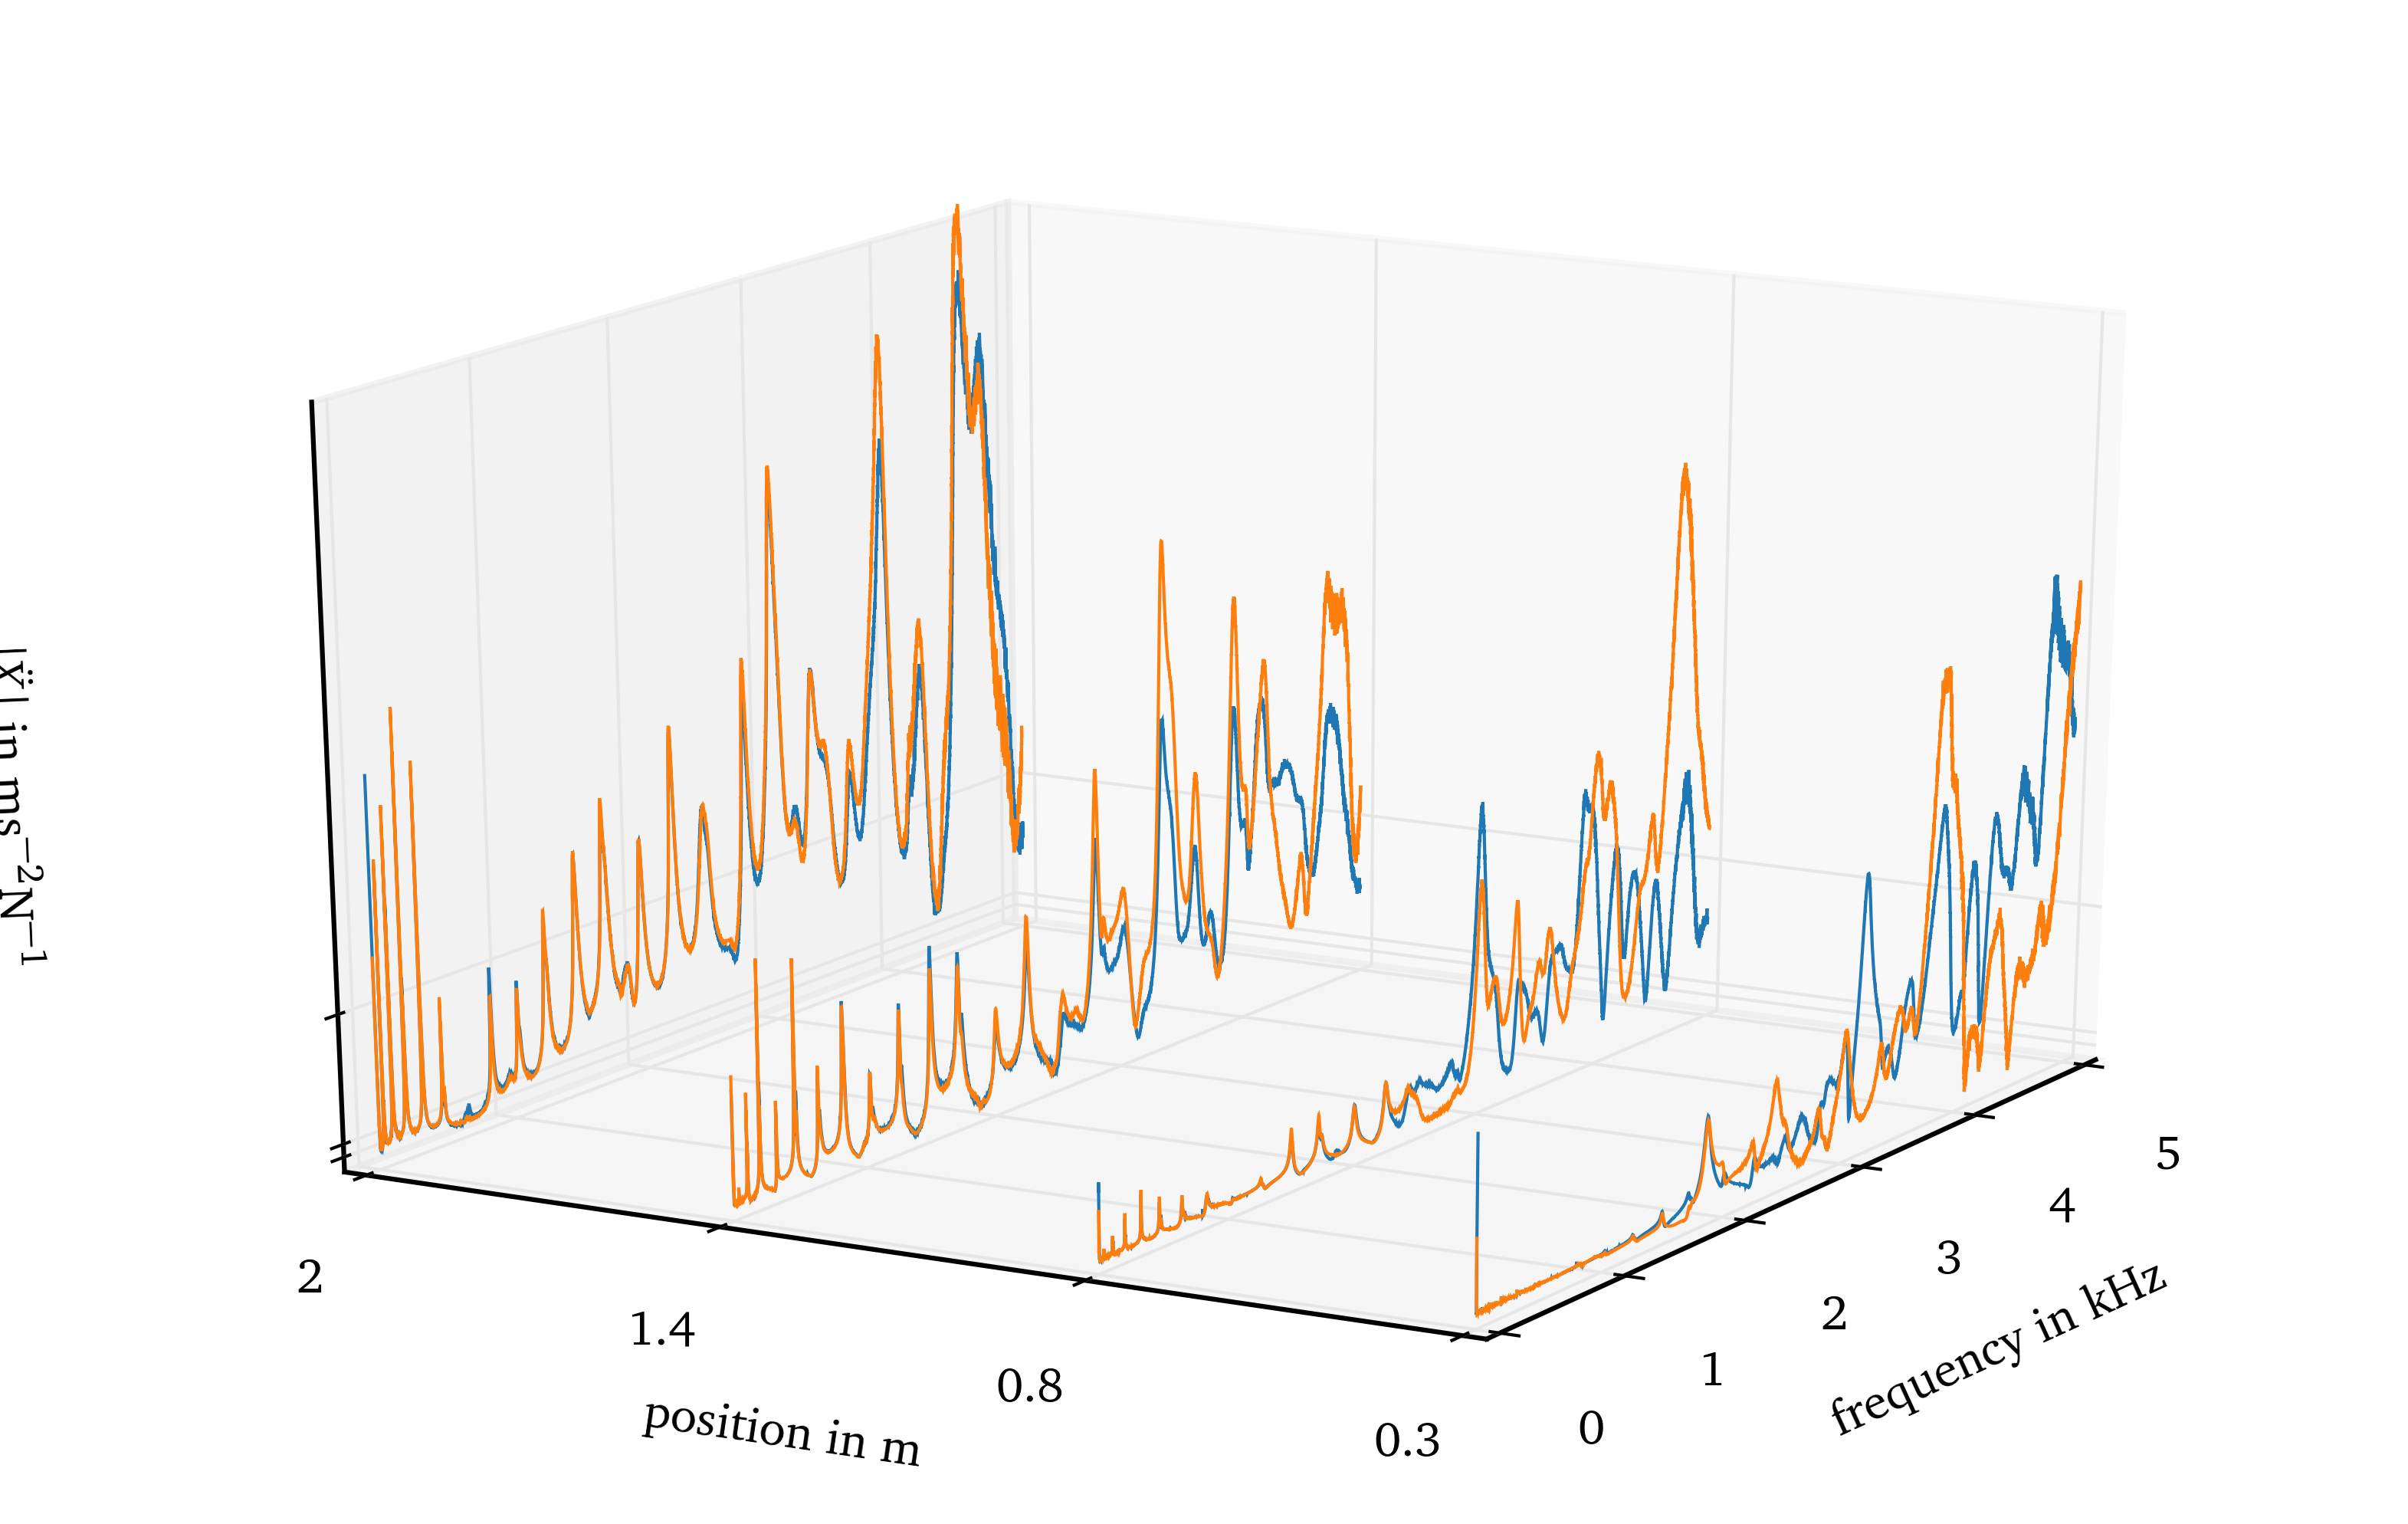

In [19]:
# Plot the FRFs at the two opposite sides of the tapered beam for four different locations

from mpl_toolkits.mplot3d import Axes3D
set_fig_size(columns=2, rows=2)
fig = plt.figure()
ax = fig.gca(projection='3d')
matplotlib.rcParams.update({'axes.labelpad': 0})

ax.plot(frfs_loc[:, 0].real/1e3, abs(frfs_loc[:, 1]), color=tbl10_colors[0], zs=0, zdir='y')
ax.plot(frfs_loc[:, 0].real/1e3, abs(frfs_loc[:, 2]), color=tbl10_colors[1], zs=0, zdir='y')
ax.plot(frfs_loc[:, 0].real/1e3, abs(frfs_loc[:, 3]), color=tbl10_colors[0], zs=2, zdir='y')
ax.plot(frfs_loc[:, 0].real/1e3, abs(frfs_loc[:, 4]), color=tbl10_colors[1], zs=2, zdir='y')
ax.plot(frfs_loc[:, 0].real/1e3, abs(frfs_loc[:, 5]), color=tbl10_colors[0], zs=4, zdir='y')
ax.plot(frfs_loc[:, 0].real/1e3, abs(frfs_loc[:, 6]), color=tbl10_colors[1], zs=4, zdir='y')
ax.plot(frfs_loc[:, 0].real/1e3, abs(frfs_loc[:, 7]), color=tbl10_colors[0], zs=6, zdir='y')
ax.plot(frfs_loc[:, 0].real/1e3, abs(frfs_loc[:, 8]), color=tbl10_colors[1], zs=6, zdir='y')
ax.set_zscale('log')
ax.set_yticks([0, 2, 4, 6])
ax.set_yticklabels(['0.3', '0.8', '1.4' ,'2'], linespacing=2.4)
ax.set_zticklabels([])
ax.set_zlim([1e-2, 5])
ax.view_init(elev=20., azim=-150)
ax.set_xlabel('frequency in kHz')
ax.set_ylabel('position in m')
ax.set_zlabel('$|\ddot{X}|$ in ms$^{-2}$N$^{-1}$');

## Flexural wavenumber estimation

$$
\lambda(x) = 2 \pi \left[ \sqrt{\frac{\omega^2}{2}\left(\frac{1}{C_s^2} + \frac{1}{C_L^2}\right) \mp \sqrt{\frac{\omega^4}{4} \left(\frac{1}{C_s^2} - \frac{1}{C_L^2}\right)^2 + \frac{4 \omega^2}{C_L^2} R_0^2 \exp{[2 \beta x]} } } \right] ^{-1}
$$ 

/home/michal/anaconda2/envs/py3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


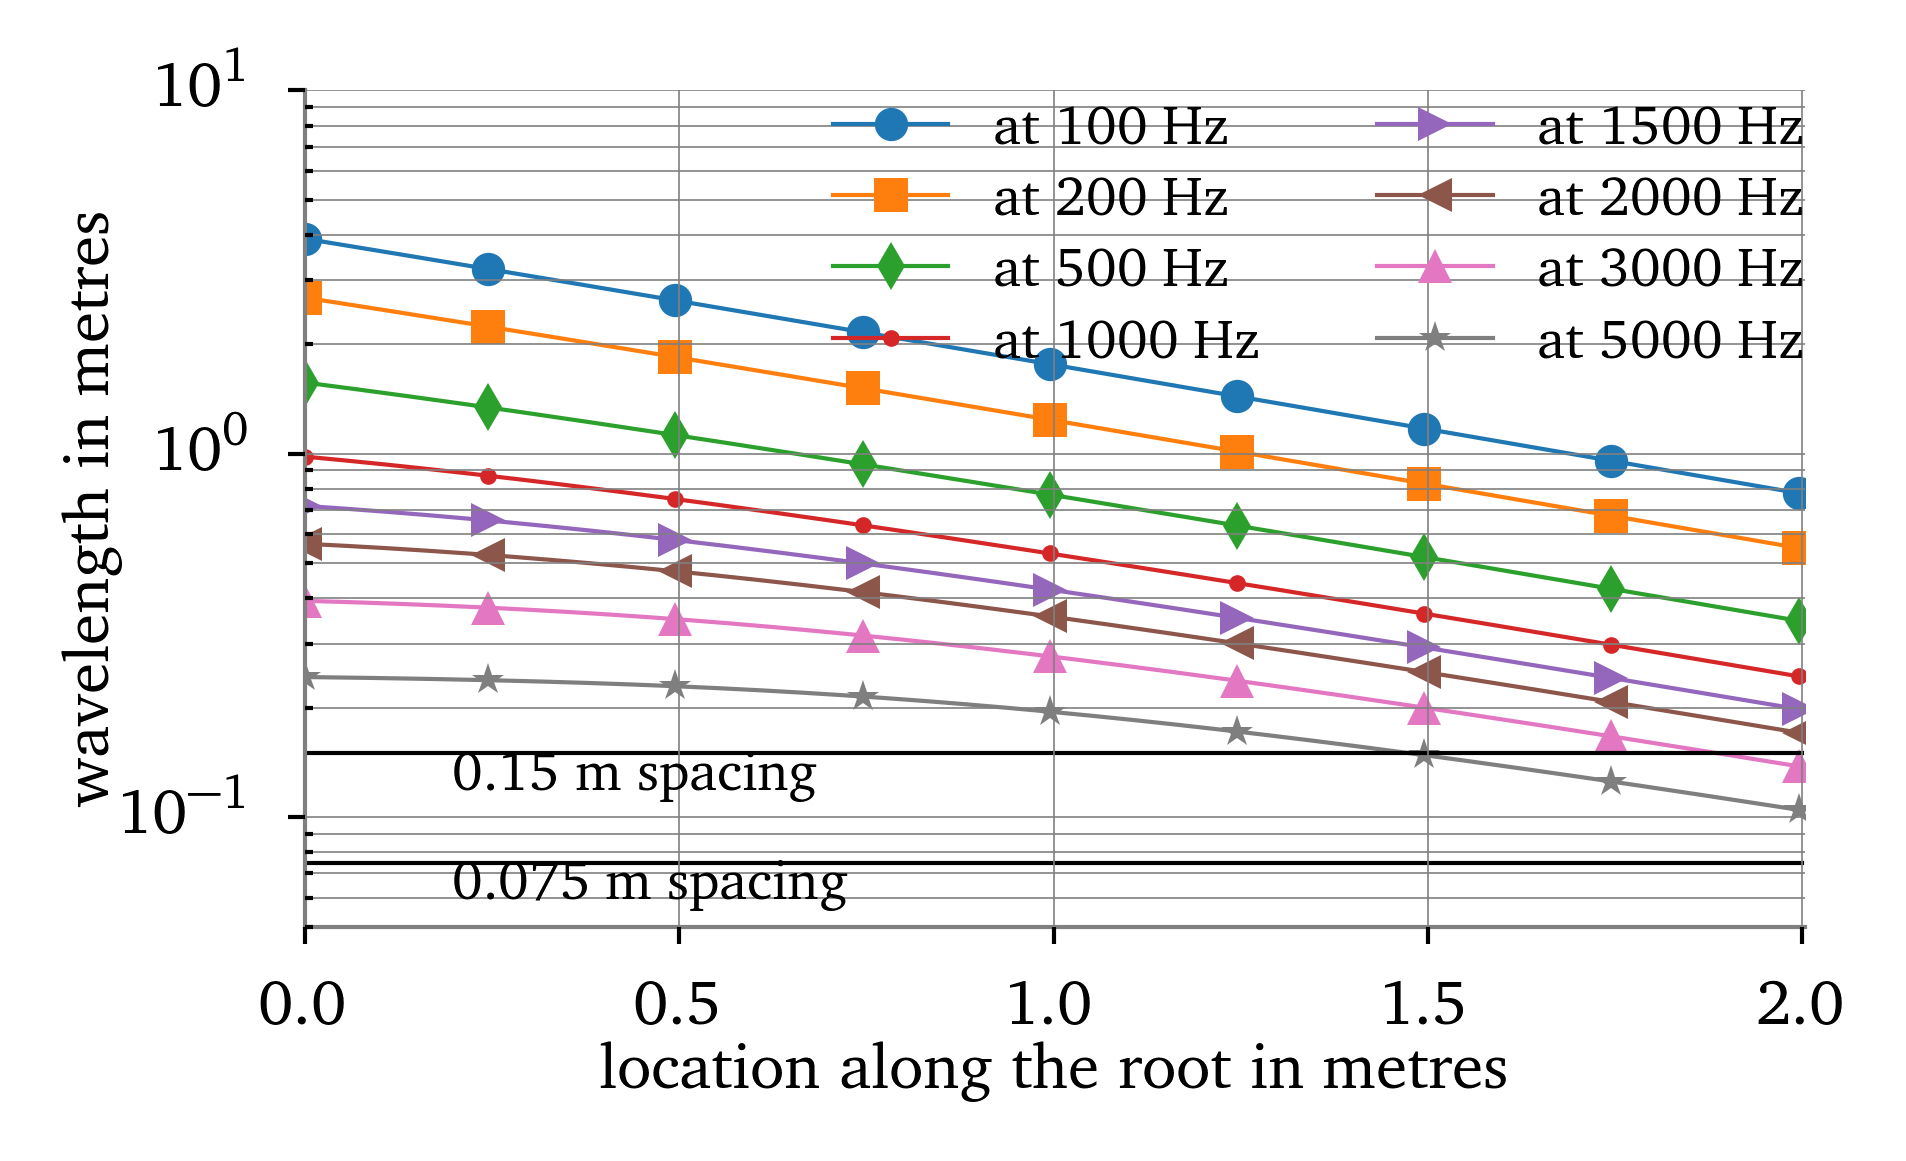

In [20]:
# Compute wavelength distribution along the tapered beam at a few chosen frequencies
# frequencies of choice
fs = np.array([100, 200, 500, 1000, 1500, 2000, 3000, 5000])

# calculate wavelengths from the wavenumbers at all specified locations for frequencies in fs
lambdas = 2*np.pi/timo_wavenumber(E, nu, rho, fs, radius, G=G)[0]

# Plot the wavelength distribution along the beam (Fig. 12)
marker_list = ['o', 's', 'd', '.', '>', '<', '^', '*']
color_list = tbl10_colors
styles = cycle(zip(marker_list, color_list))
set_fig_size(columns=1)
fig, ax = plt.subplots()
for i in range(lambdas.shape[0]):
    marker, color = next(styles)
    ax.semilogy(x_Ls, lambdas[i, :].T, color=color, marker=marker, markevery=50)
ax.plot([0, 2], [0.15, 0.15], ls='-', lw=.5, color='black')
ax.plot([0, 2], [0.075, 0.075], ls='-', lw=.5, color='black')
ax.set(yscale="log")
ax.set_xlim([0, 2.004])
ax.set_ylim([0.05, 10])
ax.set_xlabel('location along the root in metres')
ax.grid(b=True, which='minor', linewidth=0.2, ls='-', color='gray')
ax.grid(b=True, which='major', linewidth=0.2, ls='-', color='gray')

ax.set_ylabel('wavelength in metres')
ax.legend(['at '+str(np.round(fs[i], 0))+' Hz' for i in range(len(fs))], ncol=2, 
          bbox_to_anchor=(1.02, 1.02), borderaxespad=0, fontsize='x-small');
ax.annotate('0.15 m spacing', xy=(0.2, 0.12), fontsize='x-small')
ax.annotate('0.075 m spacing', xy=(0.2, 0.06), fontsize='x-small')
fig.tight_layout()
format_axes(ax)
fig.savefig('Figures/Figure12.pdf', dpi=600)

In [21]:
# Loading the measured FRFs for wavenumber estimation
flex_FRFs = np.genfromtxt('data/flexural_wavenumber_est.txt', skip_header=2, delimiter=',', dtype=np.complex128)

# locations for the FRF measurements
flex_locations = [0.25, 0.325, 0.4, 0.475, 0.55, 0.9, 0.975, 1.05, 1.125, 1.2, 1.575, 1.645, 1.65, 1.685, 1.725, 1.765, 1.8, 1.805, 1.875]


In [22]:
# helper function to plot the flexural wavenumber estimates
def plot_k_estimates(exp_set, exp_locs, num_set, num_locs,  wkb_imags, centre, spacing, fname=0, wrap=False):
    set_fig_size(columns=2, rows=2)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)
    center_ind = np.where(np.round(x_Ls, 3)==centre)[0][0]
    kk = dispe_num(round(centre, 3), spacing, exp_locs, exp_set[:, 1:])
    kknum = dispe_num(centre, spacing, num_locs, num_set)
    wkbkimag = WKB_k_imag(centre, spacing, num_locs, wkb_imags[0])
    if wrap:
        wrapping_at = f[np.argmin(abs(k_an_real[0][:, center_ind].real - np.pi/spacing))]
    ax1.plot(exp_set[:, 0].real/1e3,kk[0].real*common_exp.R0, 'o', color=tbl10_colors[8], 
             ms=2, label='experiment', rasterized=True)
    ax1.plot(exp_set[:, 0].real/1e3, kk[1].real*common_exp.R0, 'o', color=tbl10_colors[8], 
             ms=2, label='_nolegend_', rasterized=True)
    ax3.plot(exp_set[:, 0].real/1e3, -kk[0].imag*common_exp.R0*20/np.log(10), 'o', color=tbl10_colors[8],
             ms=2, label='experiment', rasterized=True)
    ax3.plot(exp_set[:, 0].real/1e3, -kk[1].imag*common_exp.R0*20/np.log(10), 'o', color=tbl10_colors[8], 
             ms=2, label='_nolegend_', rasterized=True)
    
    ax2.plot(f/1e3,kknum[0].real*common_exp.R0, 'o', color=tbl10_colors[8], ms=2, 
             label='piecewise', rasterized=True)
    ax2.plot(f/1e3, kknum[1].real*common_exp.R0, 'o', color=tbl10_colors[8], ms=2, 
             label='_nolegend_', rasterized=True)
    ax4.plot(f/1e3, -kknum[0].imag*common_exp.R0*20/np.log(10), 'o', color=tbl10_colors[8], 
             ms=2, label='piecewise', rasterized=True)
    ax4.plot(f/1e3, -kknum[1].imag*common_exp.R0*20/np.log(10), 'o', color=tbl10_colors[8], 
             ms=2, label='_nolegend_', rasterized=True)

    ax1.plot(f/1e3, k_an_real[0][:, center_ind].real*common_exp.R0, '--', color=tbl10_colors[0], 
             lw=2, label='analytical', rasterized=True)
    ax1.plot(f/1e3, -k_an_real[0][:, center_ind].real*common_exp.R0, '--', color=tbl10_colors[0], 
             lw=2, label='_nolegend_', rasterized=True)

    ax2.plot(f/1e3, k_an_real[0][:, center_ind].real*common_exp.R0, '--', color=tbl10_colors[0], 
             lw=2, label='analytical', rasterized=True)
    ax2.plot(f/1e3, -k_an_real[0][:, center_ind].real*common_exp.R0, '--', color=tbl10_colors[0], 
             lw=2, label='_nolegend_', rasterized=True)
    ax3.plot(f/1e3, -wkbkimag*common_exp.R0*20/np.log(10), '--', color=tbl10_colors[0], lw=2, 
             label='WKB', rasterized=True)
    ax4.plot(f/1e3, -wkbkimag*common_exp.R0*20/np.log(10), '--', color=tbl10_colors[0], lw=2, 
             label='WKB', rasterized=True)
    if wrap:
        ax1.plot([wrapping_at/1e3, wrapping_at/1e3], [-60, 80], '-', color='black',  label='$L_s=\lambda/2$')
        ax2.plot([wrapping_at/1e3, wrapping_at/1e3], [-60, 80], '-', color='black',  label='$L_s=\lambda/2$')
        ax3.plot([wrapping_at/1e3, wrapping_at/1e3], [-10, 30], '-', color='black',  label='$L_s=\lambda/2$')
        ax4.plot([wrapping_at/1e3, wrapping_at/1e3], [-10, 30], '-', color='black',  label='$L_s=\lambda/2$')
    maxk = np.max(kk[1].real*common_exp.R0)
    ax1.set_ylim([-1.8*maxk, 1.8*maxk])
    ax2.set_ylim([-1.8*maxk, 1.8*maxk])
    ax3.set_ylim([-8, 5])
    ax4.set_ylim([-8, 5])
    leg1 = ax1.legend(ncol=3, fontsize='xx-small', frameon=True)
    leg2 = ax2.legend(ncol=3, fontsize='xx-small', frameon=True)
    leg3 = ax3.legend(ncol=3, fontsize='xx-small', frameon=True)
    leg4 = ax4.legend(ncol=3, fontsize='xx-small', frameon=True)
    leg1.get_frame().set_linewidth(0.0)
    leg2.get_frame().set_linewidth(0.0)
    leg3.get_frame().set_linewidth(0.0)
    leg4.get_frame().set_linewidth(0.0)
    ax1.set_ylabel('Re($k R_0$)')
    ax3.set_ylabel('attenuation in dB/$R_0$')
    ax3.set_xlabel('frequency in kHz')
    ax4.set_xlabel('frequency in kHz')
    ax1.annotate('(a)', xy=(-0.2, 1.05), xycoords='axes fraction')
    ax2.annotate('(b)', xy=(-0.17, 1.05), xycoords='axes fraction')
    ax3.annotate('(c)', xy=(-0.2, 1.05), xycoords='axes fraction')
    ax4.annotate('(d)', xy=(-0.17, 1.05), xycoords='axes fraction')
    fig.subplots_adjust(wspace=0.3)
    format_axes([ax1, ax2, ax3, ax4])
    if fname != 0:
        fig.savefig(fname, dpi=600)
    plt.show()

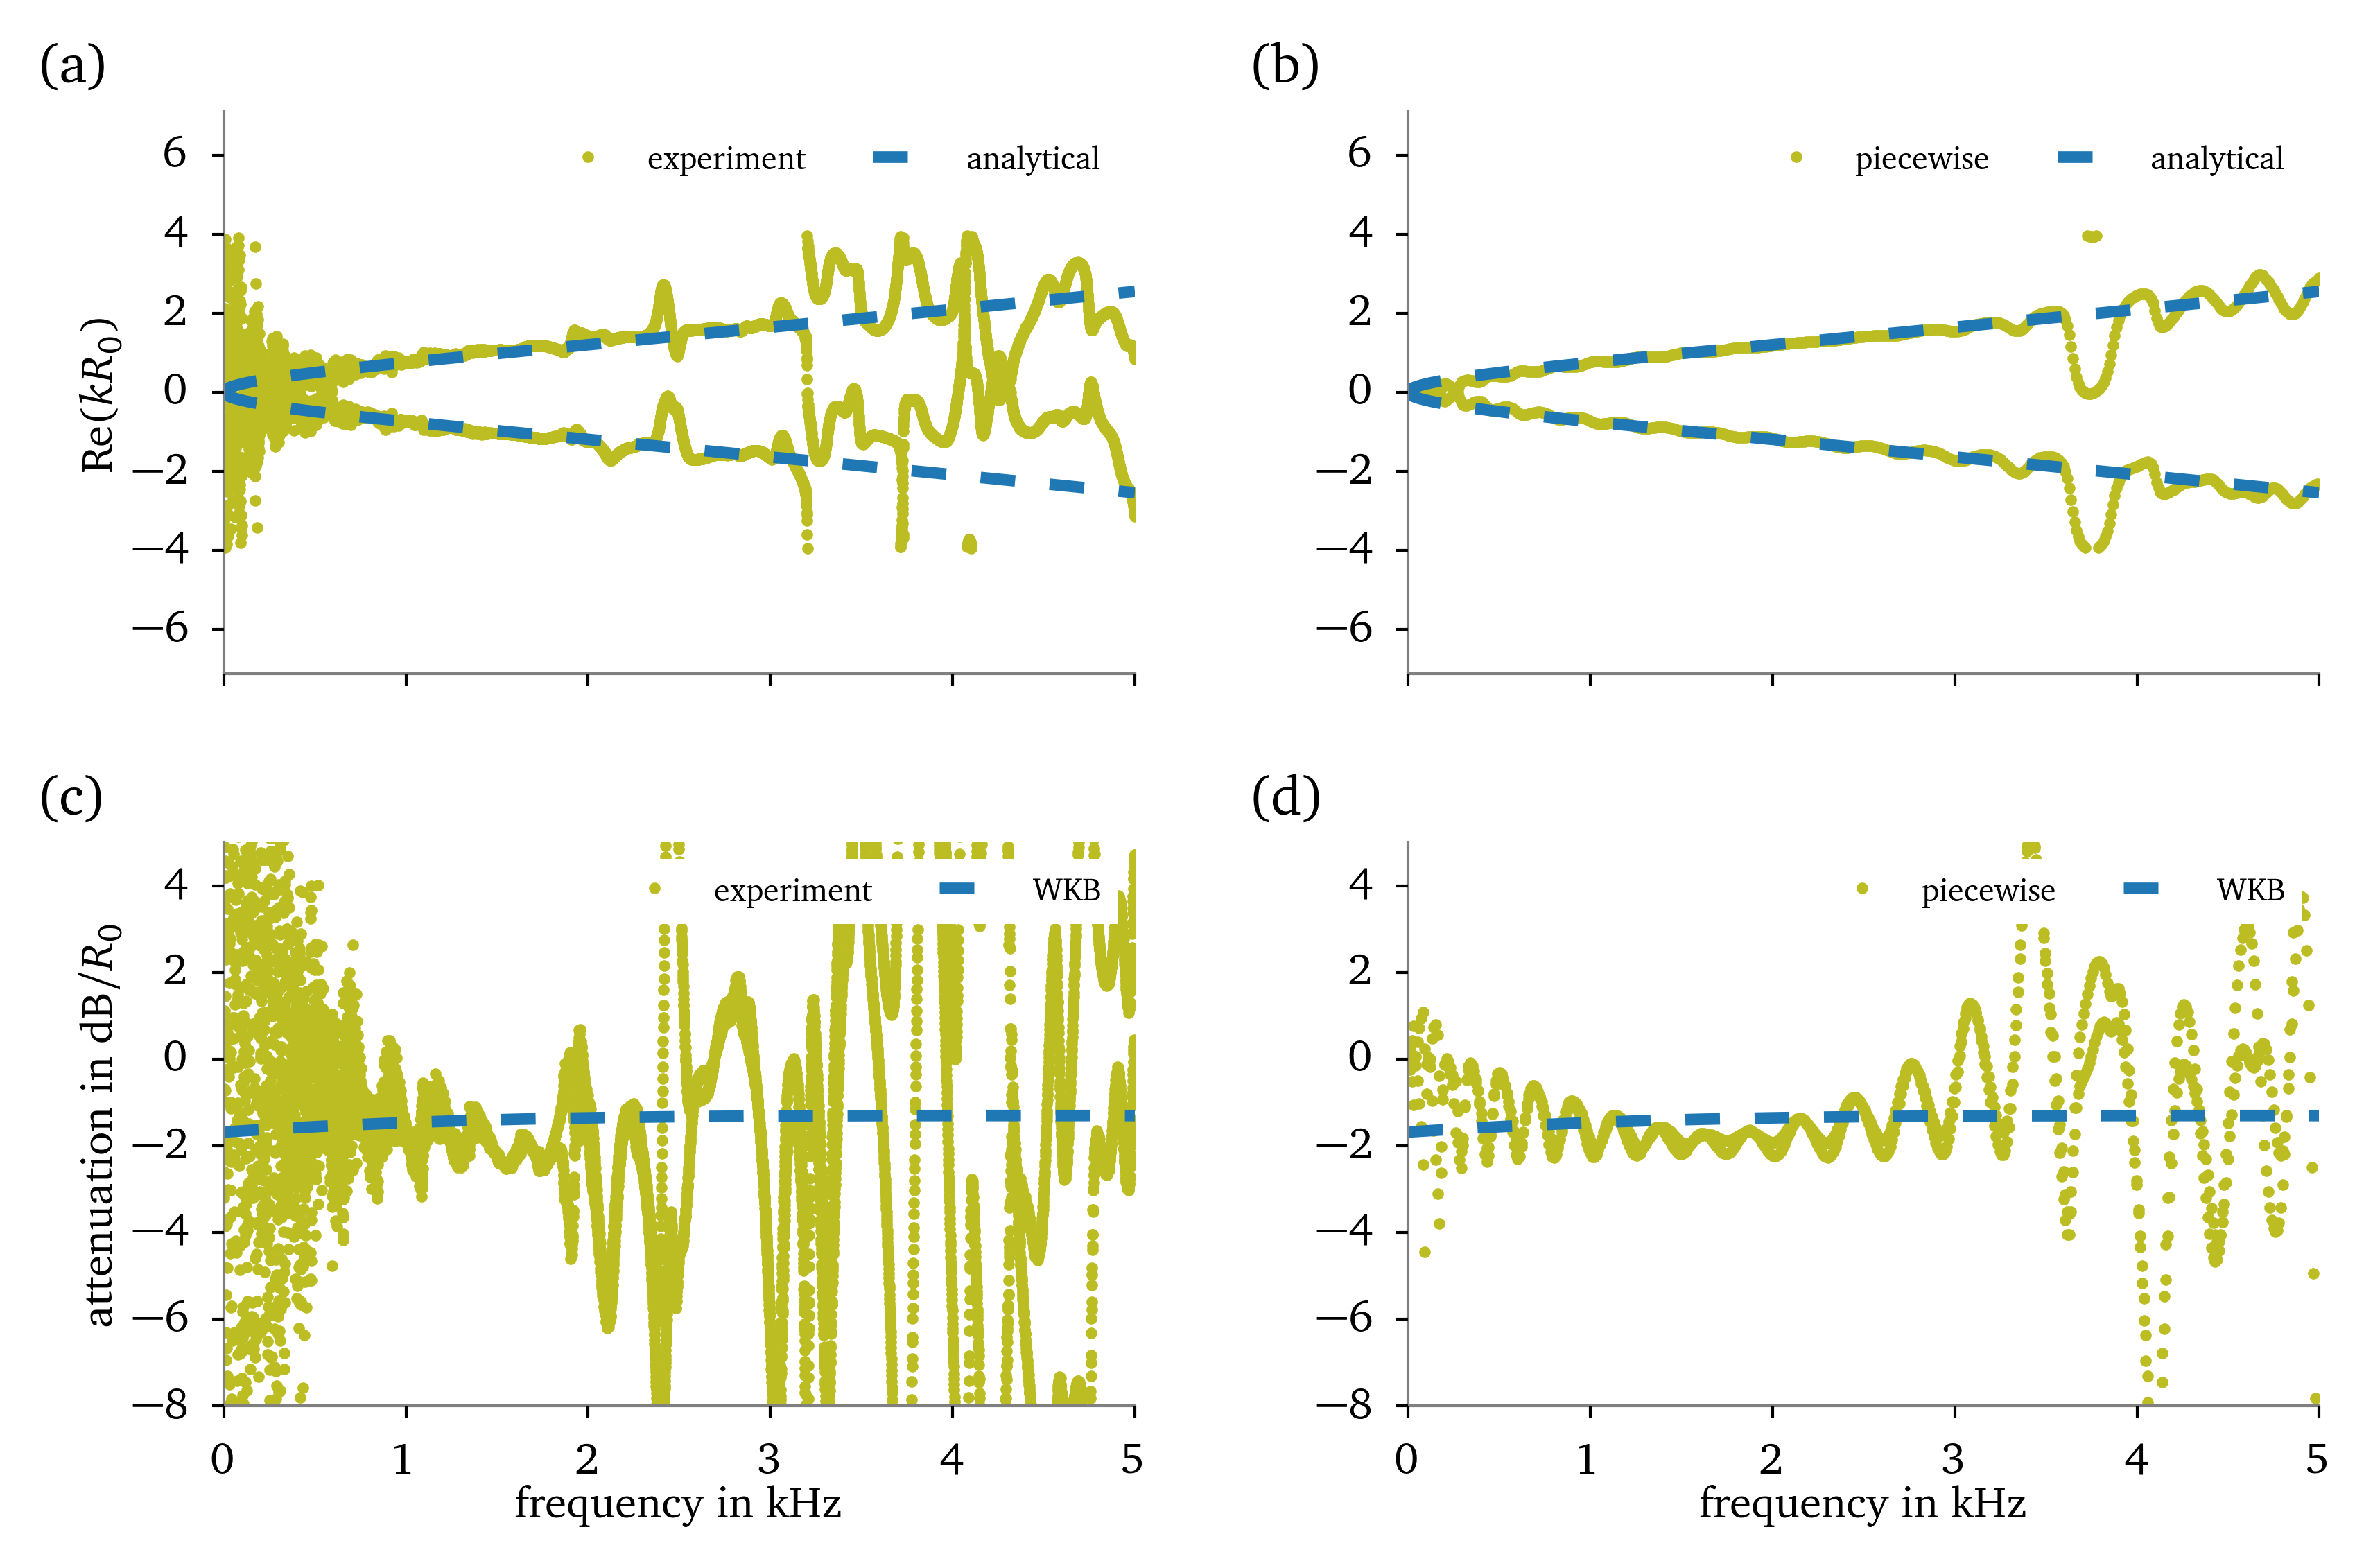

In [23]:
# Fig. 13
plot_k_estimates(flex_FRFs, flex_locations, resp_pu, x_Ls,
                 WKB_ampls, 0.4, 0.075, fname='Figures/Figure13.pdf')

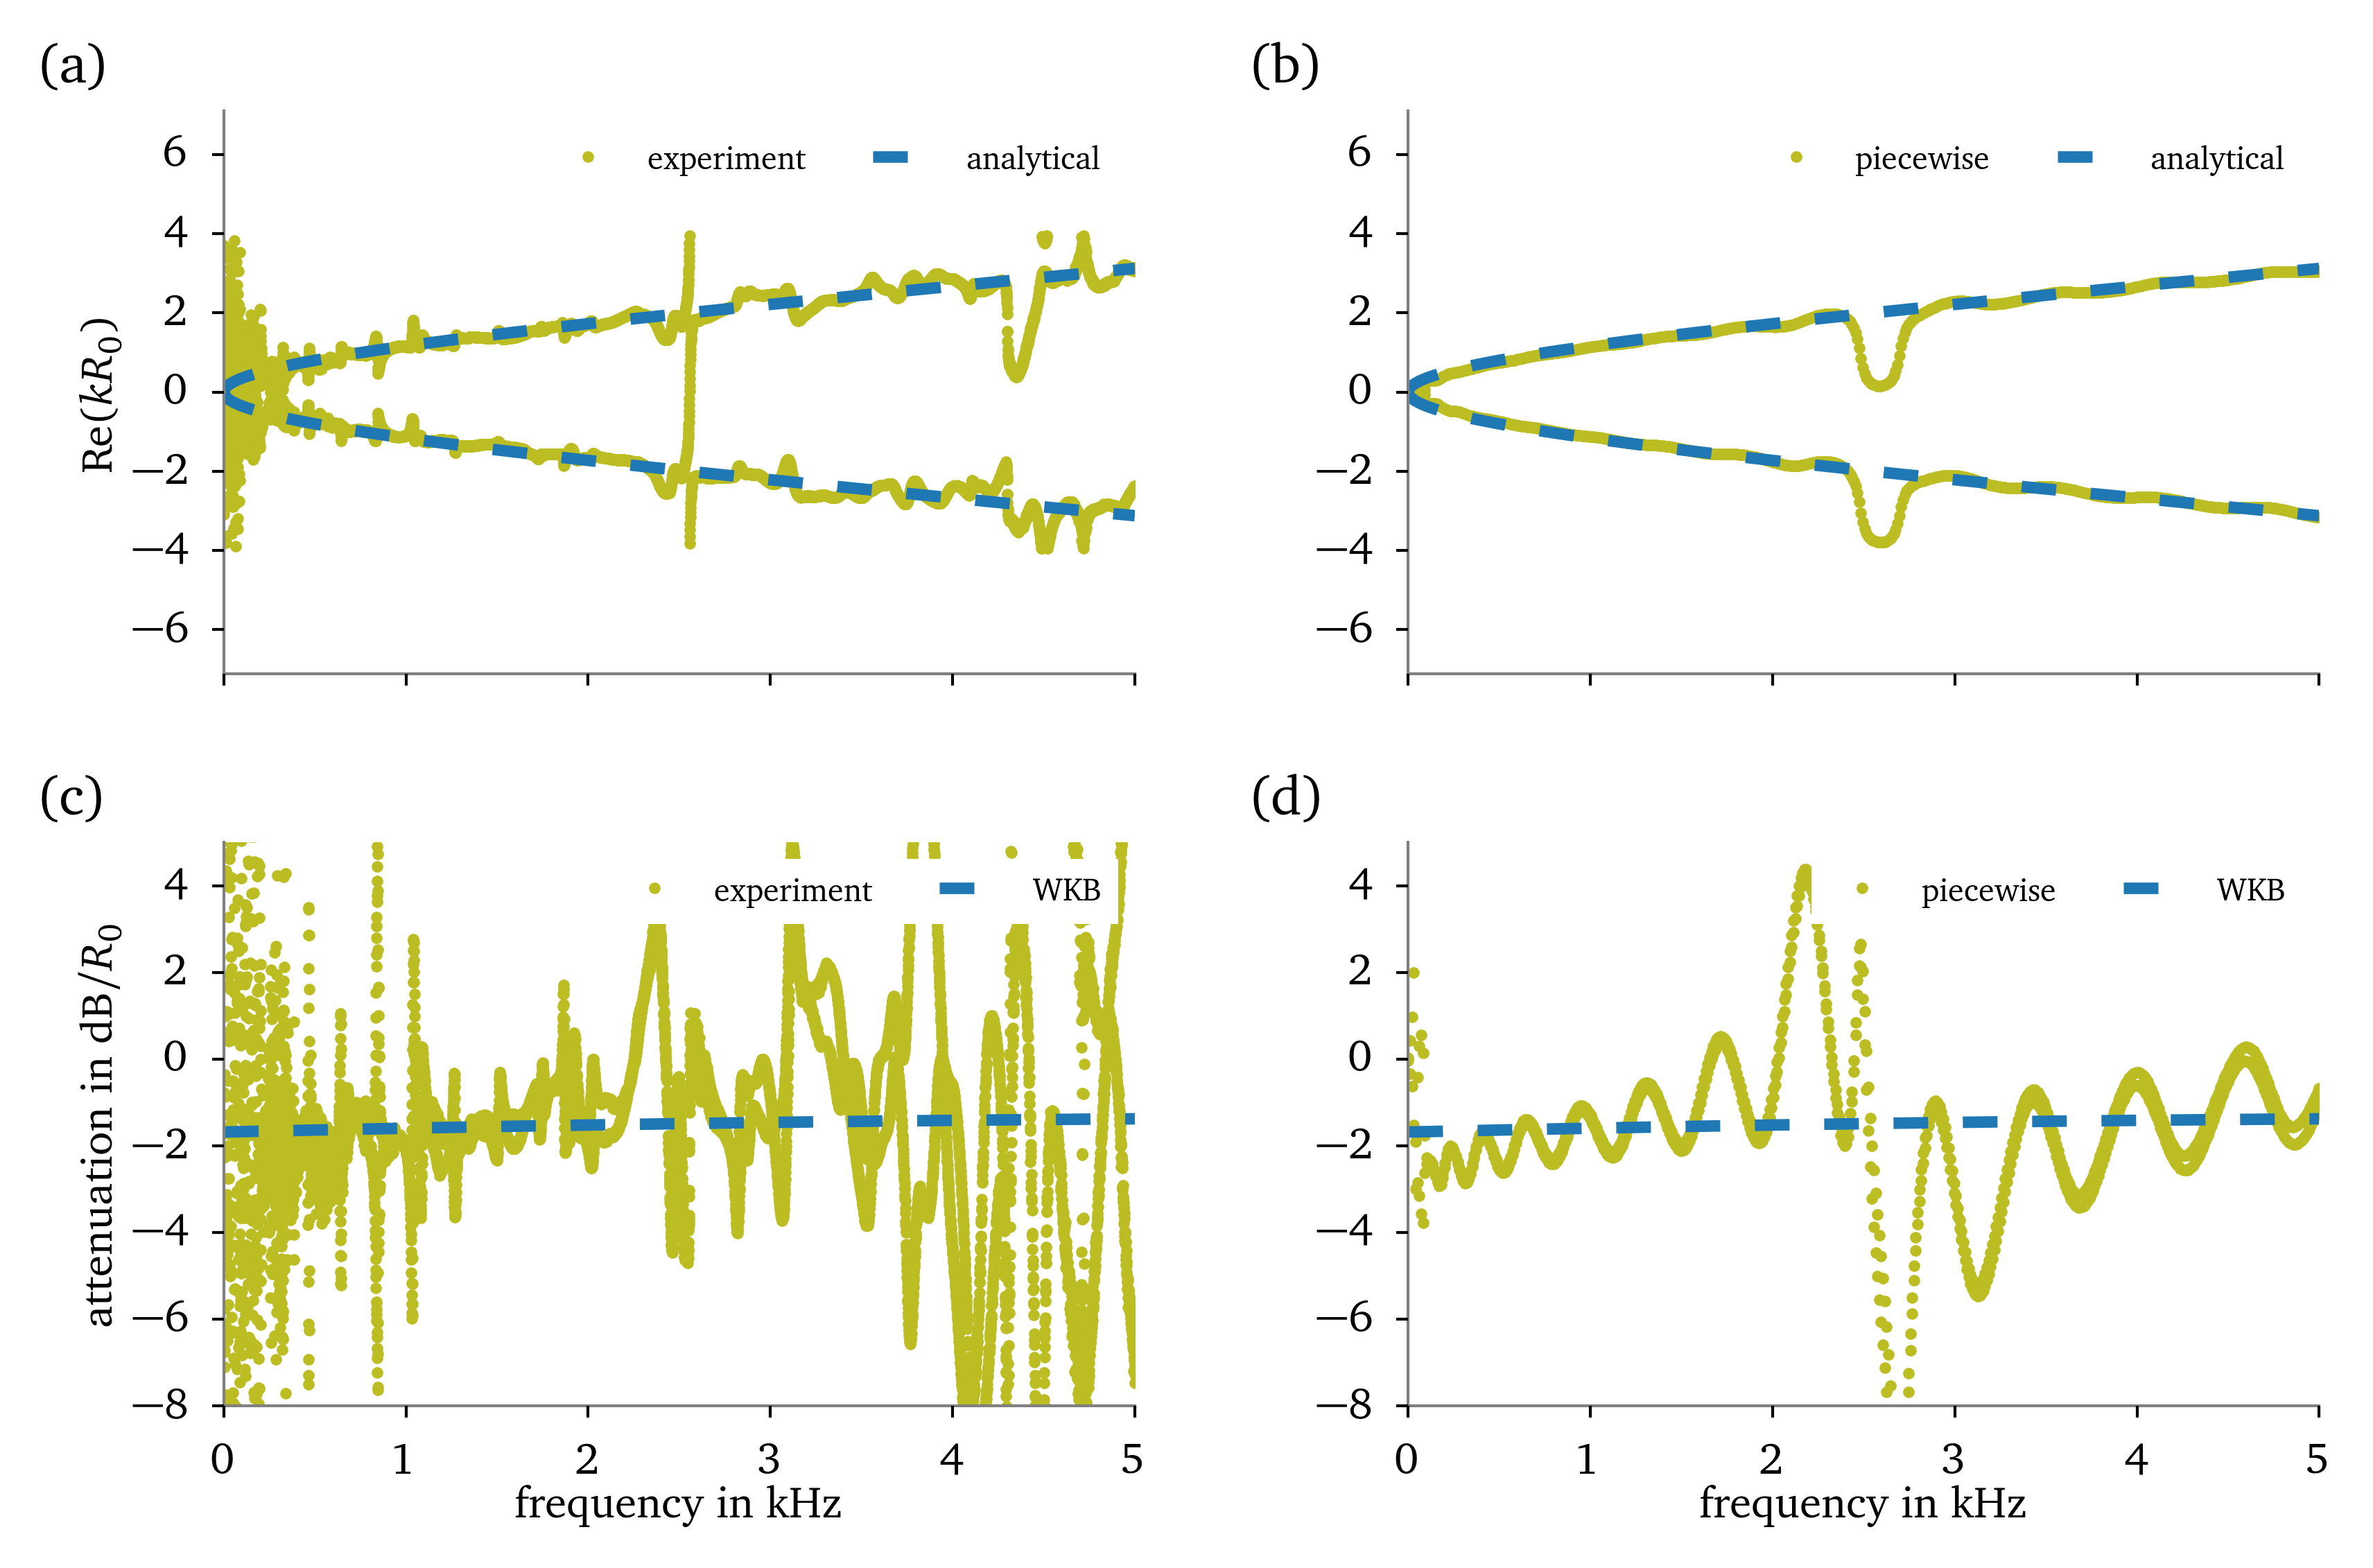

In [24]:
#Fig. 14
plot_k_estimates(flex_FRFs, flex_locations, resp_pu, x_Ls,
                 WKB_ampls, 1.05, 0.075, fname='Figures/Figure14.pdf')

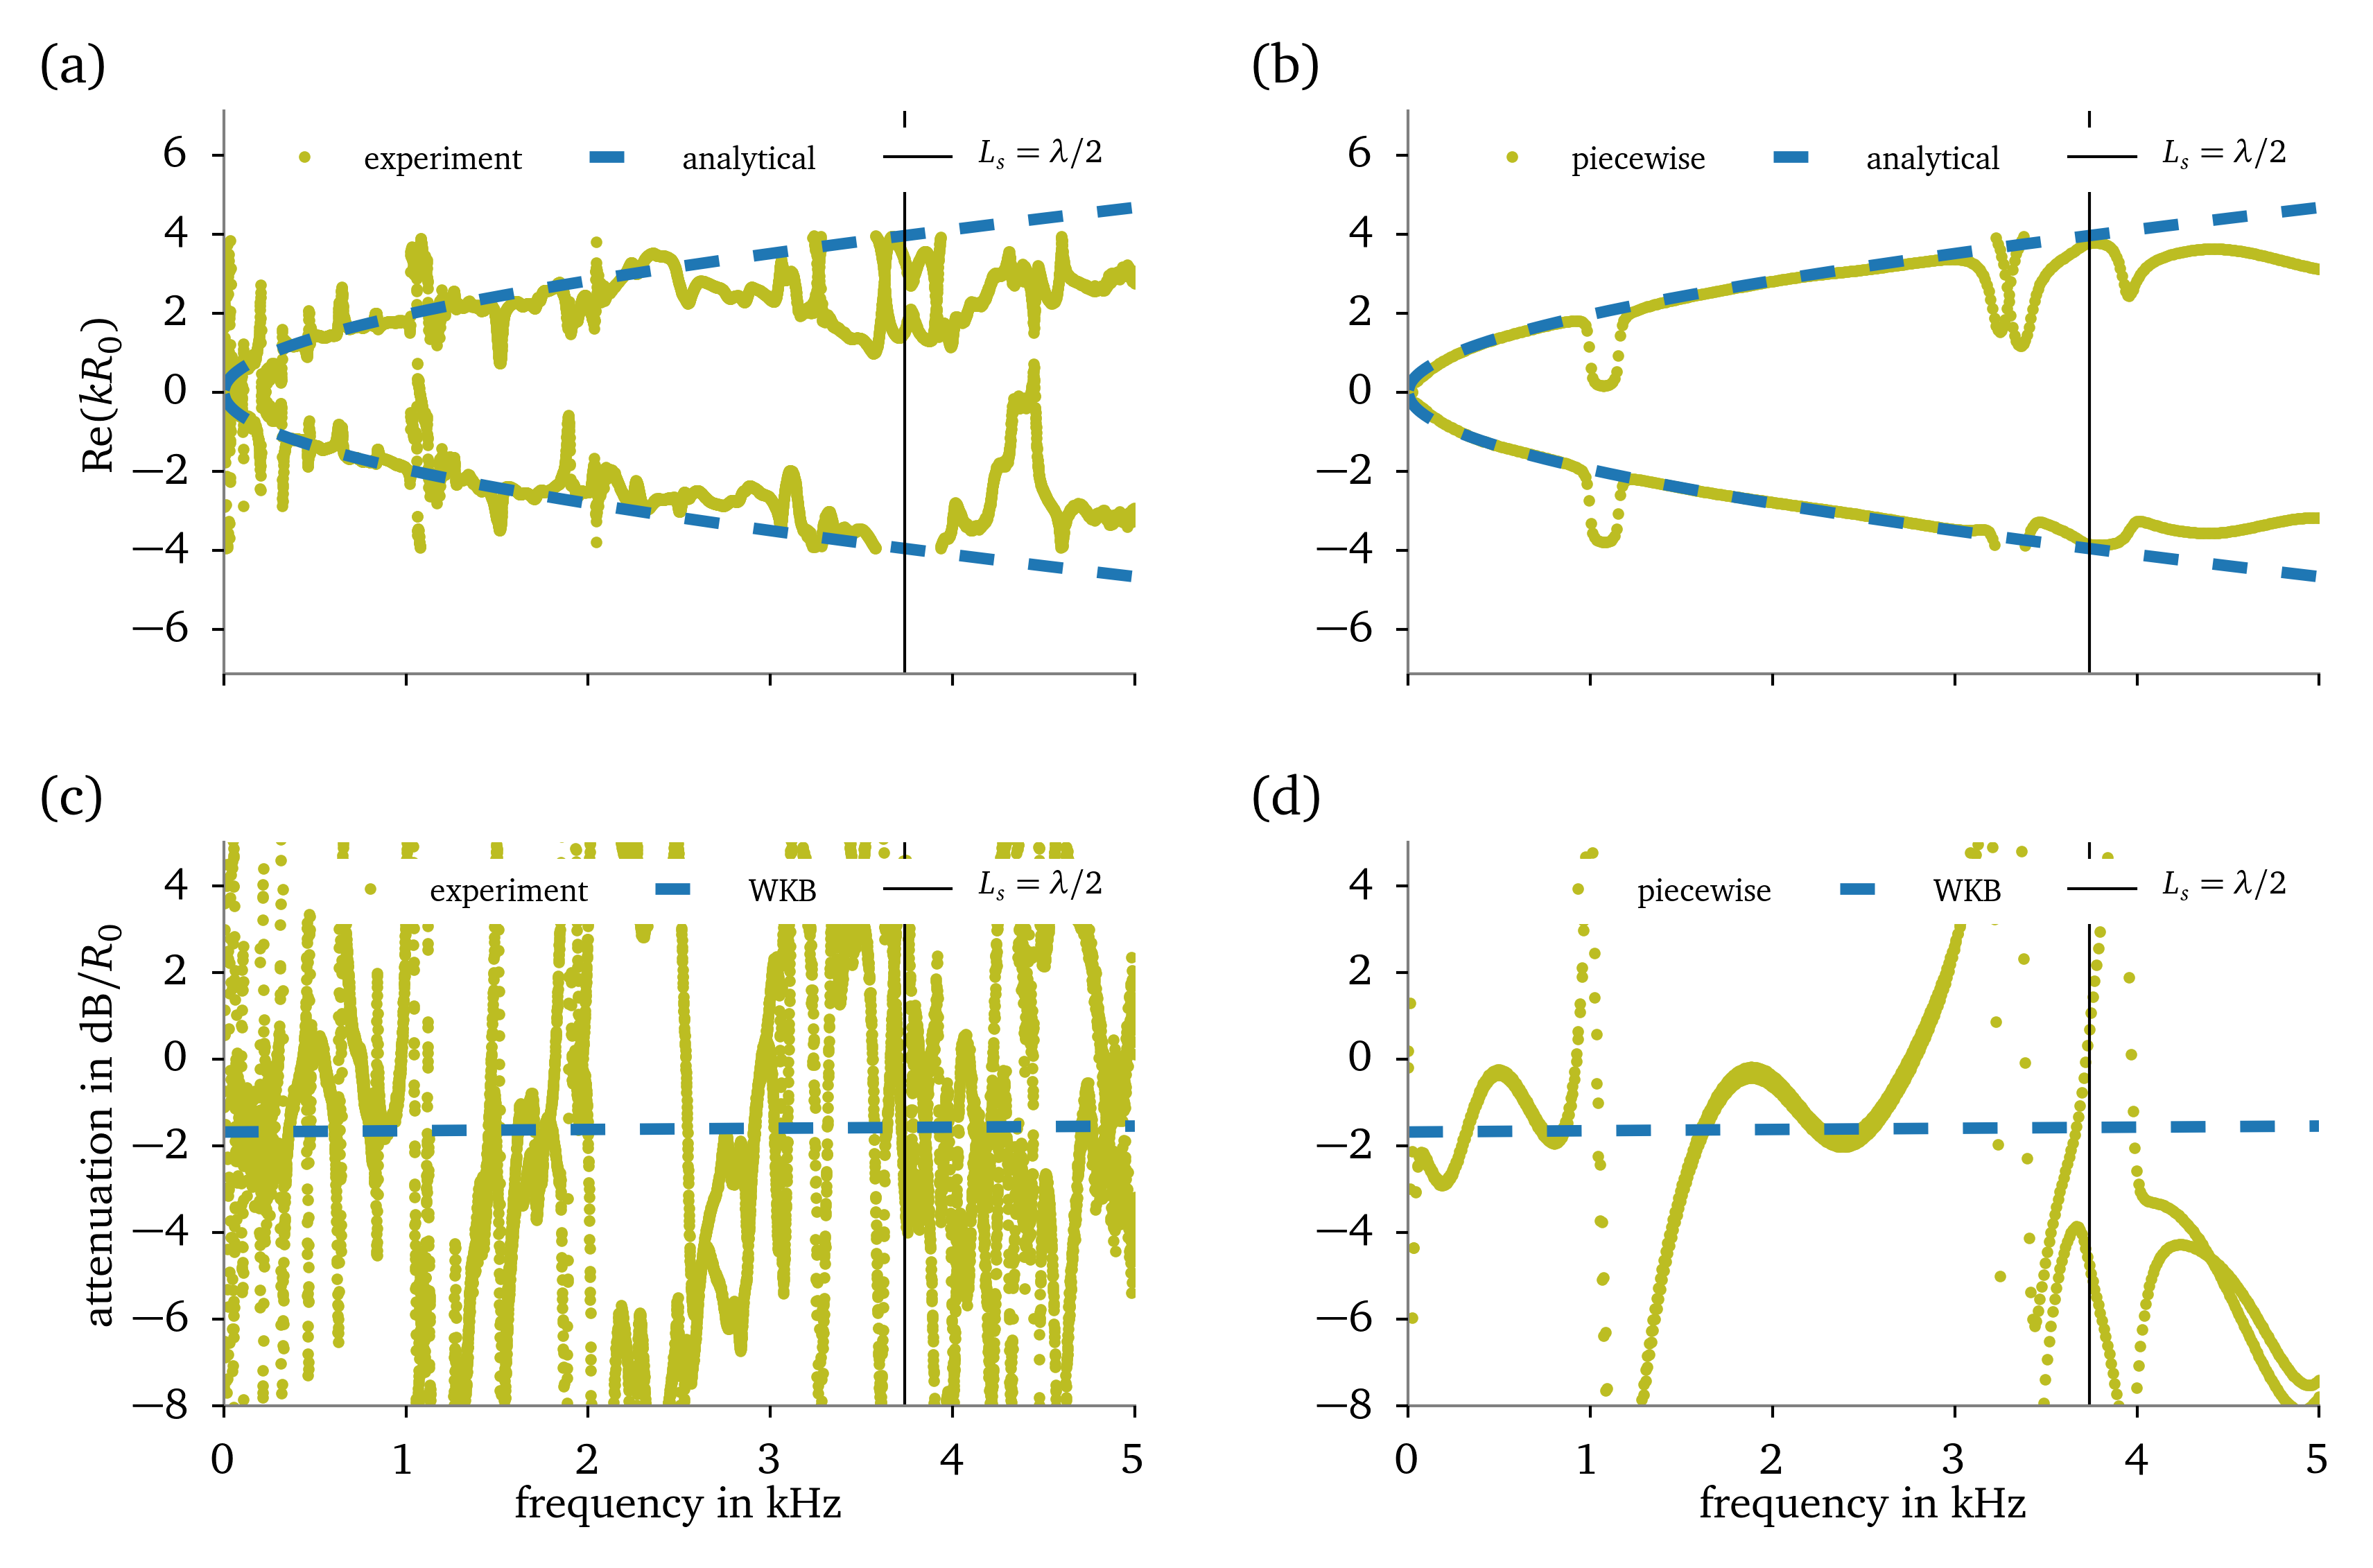

In [25]:
#Fig. 15
plot_k_estimates(flex_FRFs, flex_locations, resp_pu, x_Ls,
                 WKB_ampls, 1.725, 0.075, wrap=True, fname='Figures/Figure15.pdf')

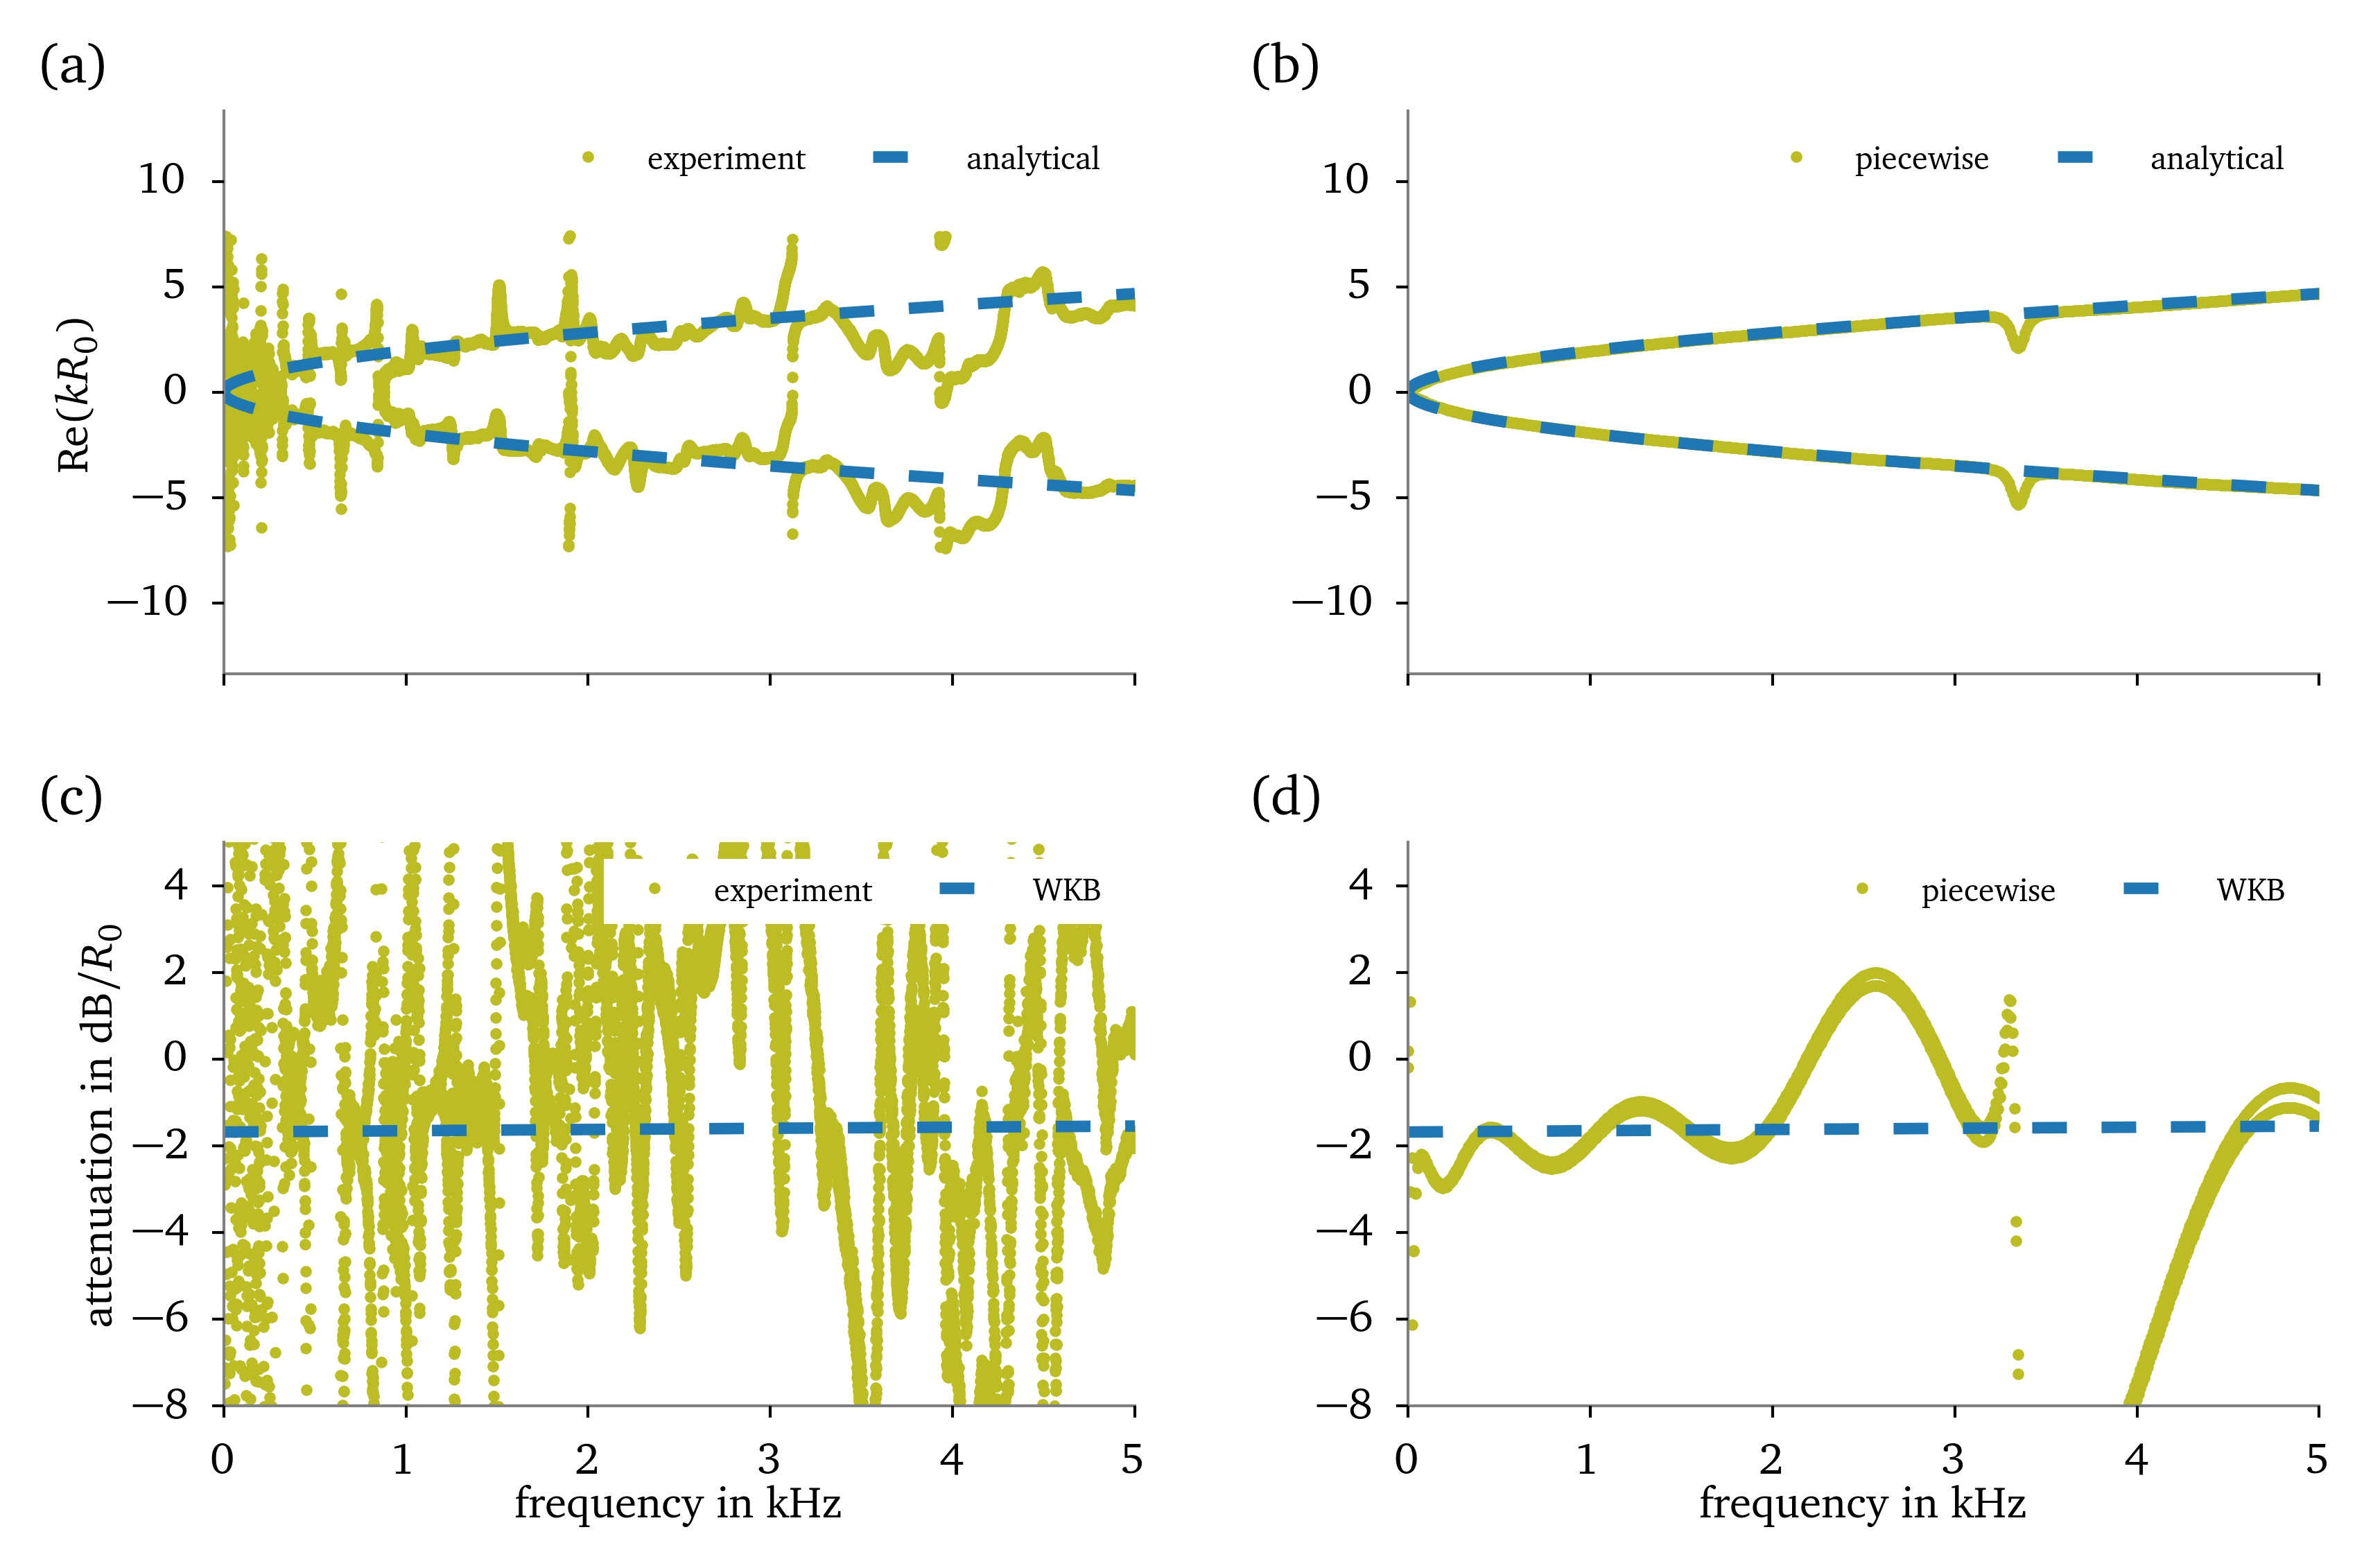

In [26]:
# Fig. 16
plot_k_estimates(flex_FRFs, flex_locations, resp_pu, x_Ls,
                 WKB_ampls, 1.725, 0.04, fname='Figures/Figure16.pdf')